# Packages

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import shapely.geometry as shp
import fiona

import math
import time
from collections import defaultdict

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Geospatial Analysis\\Geospatial Data Science with Python - Geopandas'

# General Functions

ERROR! Session/line number was not unique in database. History logging moved to new session 796


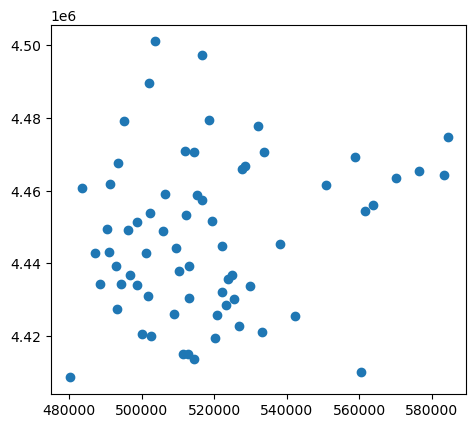

In [120]:
fpath = 'geopandas_data/geopandas/data'

eagle = gpd.read_file(f'{fpath}/BAEA_Nests.shp')
eagle.to_crs(epsg = 26913, inplace = True)
eagle.plot()
plt.show()

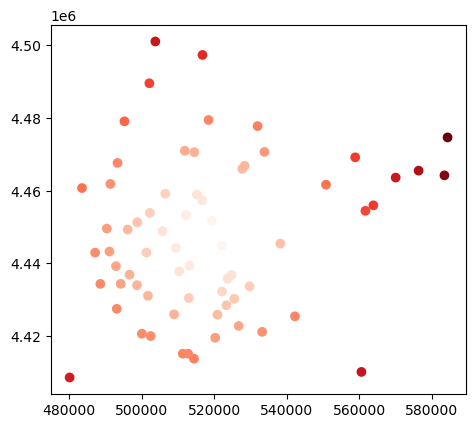

In [121]:
eagle_center = shp.Point(eagle['geometry'].x.mean(), eagle['geometry'].y.mean())
eagle['distance_to_center'] = eagle['geometry'].distance(eagle_center)
eagle.plot(column = 'distance_to_center', cmap = 'Reds')
plt.show()

In [122]:
eagle = eagle[eagle['distance_to_center'] < 46000]

## Spatial predicates

This compares two geometries and returns `True` and `False`. We discussed the intersects predicate previously but there are many more.
- *.intersects(other)* returns true if any part of the geometry it is called on touches any part of another geometry
- *.equals(other)* returns true if the geometries are exactly equivalent
- *.almost_equal(other, tolerance)* returns true if the geometries are equal within the given tolerance level.
- *.contains(other)* returns true if the geometry it is called in completely encompasses the other
- *.within(other)* the opposite of contains

Other spatial predicates include *touches, crosses, overlap, disjoint*.

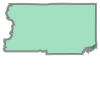

In [123]:
counties = gpd.read_file(f'{fpath}/colorado_counties.shp')
boulder_county = counties[counties['NAMELSAD10'] == 'Boulder County'].unary_union
boulder_county

In [124]:
# Read raptor file
raptors = gpd.read_file(f'{fpath}/Raptor_Nests.shp')
raptors

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891)
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089)
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694)
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215)
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571)
...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297)
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975)
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432)
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443)


In [125]:
# View subset of raptor nests within Boulder county
boulder_nests = raptors[raptors['geometry'].within(boulder_county)]
boulder_nests.describe()

,postgis_fi,lat_y_dd,long_x_dd,Nest_ID
count,40.000000,40.000000,40.000000,40.000000
mean,579.525000,40.080592,-105.070582,579.525000
std,289.469363,0.061656,0.058305,289.469363
min,14.000000,39.986176,-105.160108,14.000000
25%,366.500000,40.049635,-105.128486,366.500000
50%,763.000000,40.062365,-105.062450,763.000000
75%,806.250000,40.119383,-105.029655,806.250000
max,889.000000,40.218405,-104.970574,889.000000


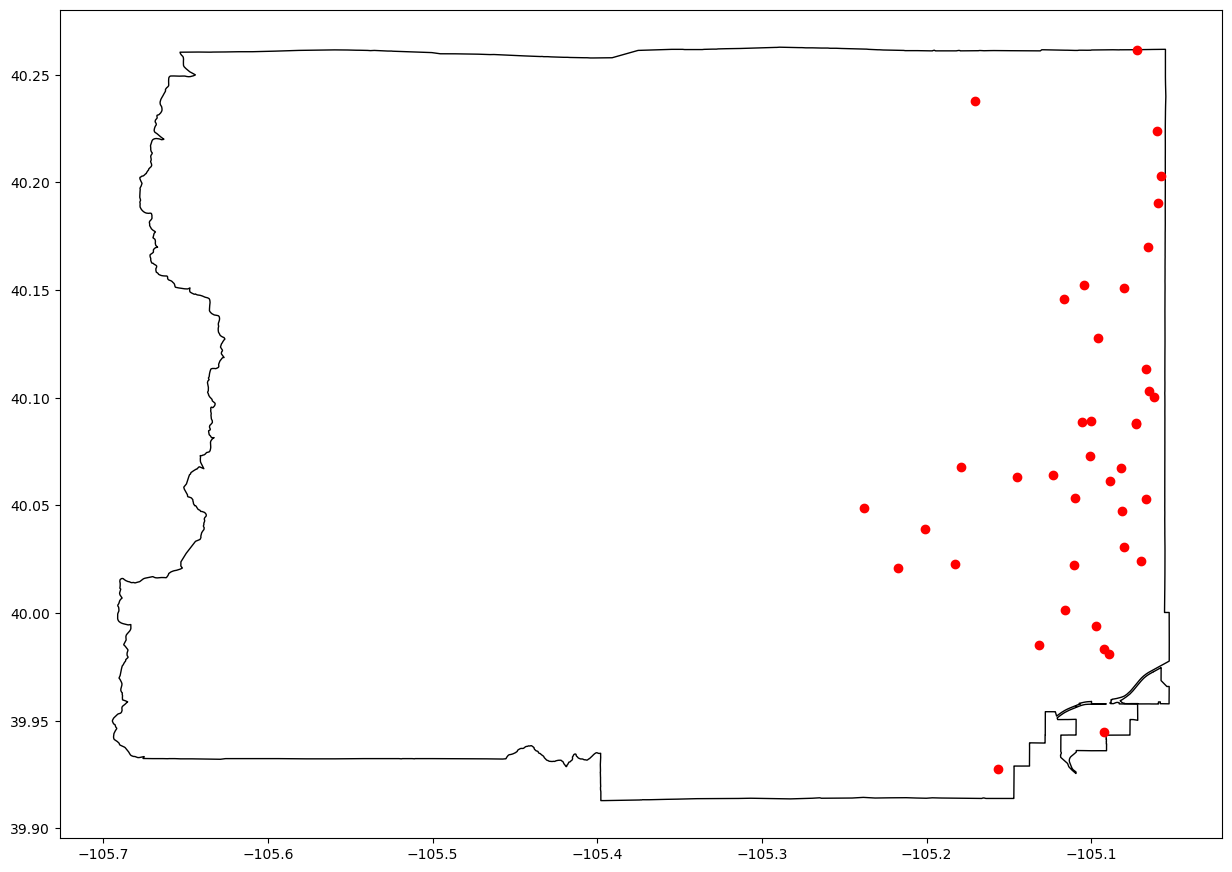

In [126]:
basemap = counties[counties['NAMELSAD10']=='Boulder County'].plot(facecolor = 'none', edgecolor = 'k', figsize = (15, 15))
boulder_nests.plot(ax = basemap, color = 'red')
plt.show()

## Spatial operators

We have looks at the intersection operator. Others include union with is a spatial OR operator. Symmetric difference is a spatial XOR operator, including areas that are in one OR the other but NOT in both. Difference is a spatial subtraction, removing the area in the other geometry from the geometry that it is called on.

Let's look at an example of using the difference operator to make ring buffers around the burrowing owl habitat. First, we will read in the buowl habitat shapefile, then convert it to UTM coordinates and create a 300m buffer.

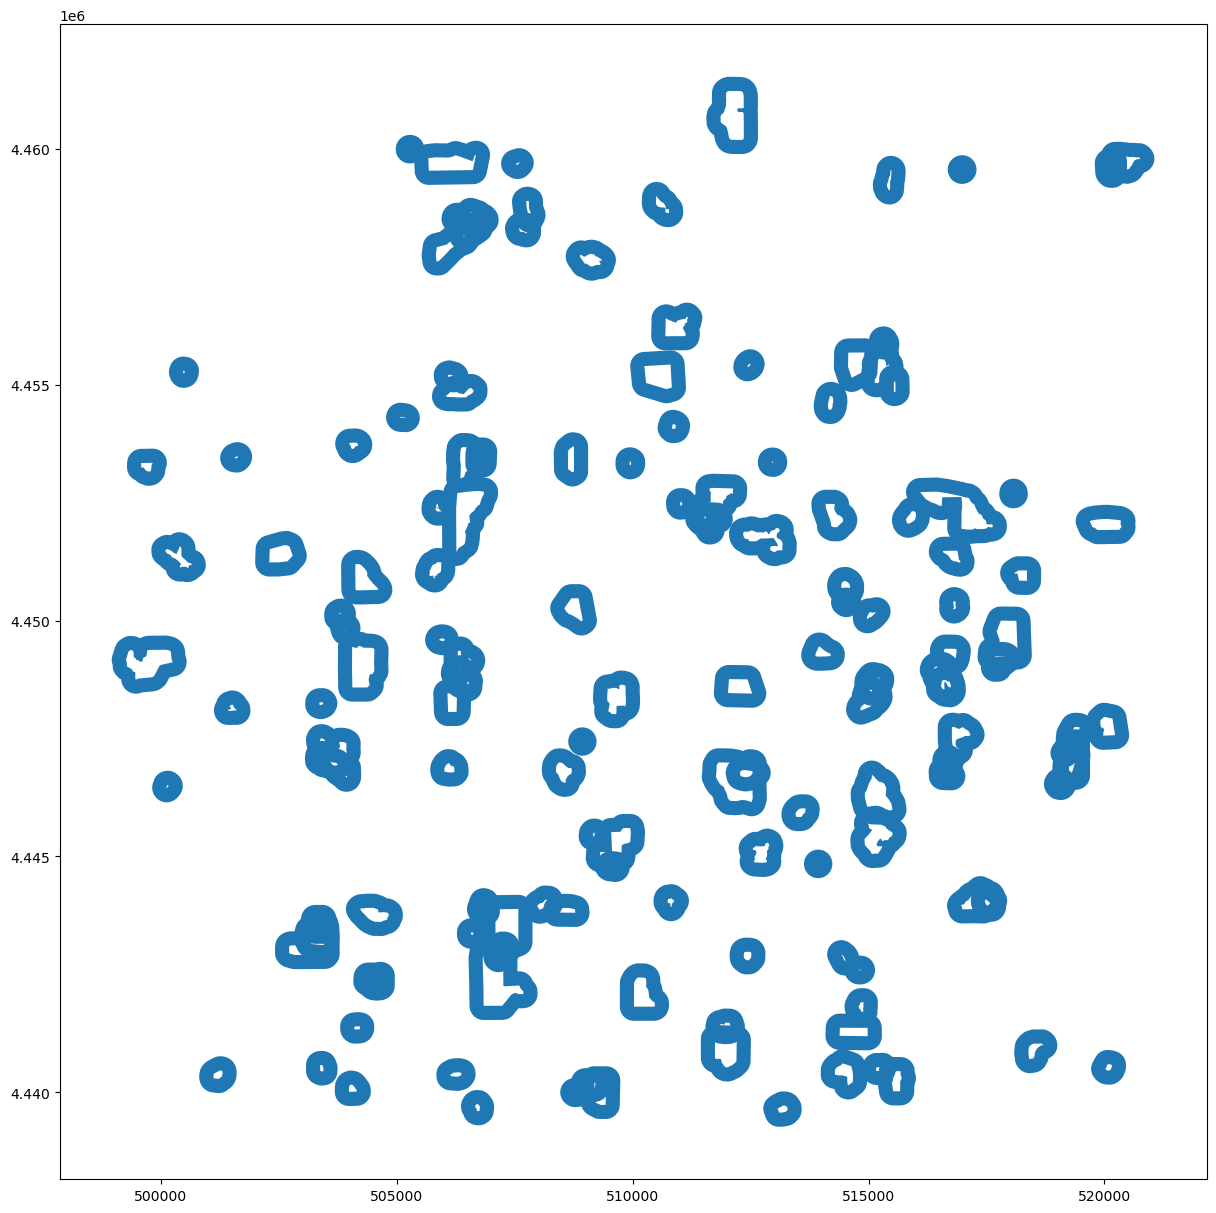

In [127]:
buowl = gpd.read_file(f'{fpath}/BUOWL_Habitat.shp')
buowl.to_crs(epsg = 26913, inplace = True)
buowl['buffer'] = buowl['geometry'].buffer(300)

# Create ring buffers by subtracting original geometry from buffer
# Fix invalid geometries
buowl['geometry'] = buowl['geometry'].buffer(0)
buowl['ring_buffer'] = buowl['buffer'].difference(buowl['geometry'])
buowl.set_geometry('ring_buffer').cx[500000:520000, 4440000:4460000].plot(figsize = (15, 15))
plt.show()

In [128]:
# If we calculate the areas of all three geometries, we see that
# Area of original geometry plus ring buffer = buffer area
buowl['area_ha'] = buowl['geometry'].area / 10000
buowl['buffer_ha'] = buowl['buffer'].area / 10000
buowl['ring_ha'] = buowl['ring_buffer'].area / 10000
buowl['buf_minus_ring_ha'] = buowl['buffer_ha'] - buowl['ring_ha']
buowl

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,buffer,ring_buffer,area_ha,buffer_ha,ring_ha,buf_minus_ring_ha
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((532623.765 4446446.072, 532633.280 4...","POLYGON ((532374.983 4446613.725, 532392.784 4...","POLYGON ((532392.784 4446637.509, 532412.850 4...",2.625347,65.084303,62.458956,2.625347
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((529788.325 4443598.447, 529801.976 4...","POLYGON ((529522.846 4443738.165, 529537.780 4...","POLYGON ((529537.780 4443763.455, 529555.116 4...",0.030492,30.292668,30.262176,0.030492
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((534158.811 4440267.074, 534171.569 4...","POLYGON ((533860.014 4440240.227, 533858.817 4...","POLYGON ((533858.817 4440268.952, 533860.374 4...",0.054011,30.979443,30.925432,0.054011
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((526066.374 4447636.016, 526085.982 4...","POLYGON ((525788.576 4447522.752, 525778.898 4...","POLYGON ((525778.898 4447550.239, 525771.932 4...",0.030381,30.635224,30.604843,0.030381
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((526901.134 4449915.454, 526893.541 4...","POLYGON ((526276.173 4449974.497, 526275.827 4...","POLYGON ((526275.827 4449989.128, 526277.495 4...",12.423248,83.636711,71.213463,12.423248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,447.0,Active Prairie Dog Colony,Yes,ACTIVE NEST,447,FALSE,"POLYGON ((550582.960 4479403.758, 550509.254 4...","POLYGON ((550870.680 4479318.804, 550861.026 4...","POLYGON ((550861.026 4479291.154, 550848.720 4...",2.869939,49.718217,46.848278,2.869939
469,449.0,Active Prairie Dog Colony,Yes,ACTIVE NEST,449,FALSE,"POLYGON ((551948.916 4480978.294, 551945.826 4...","POLYGON ((551580.403 4481296.895, 551590.305 4...","POLYGON ((551590.305 4481308.878, 551591.839 4...",10.331338,105.386242,95.054904,10.331338
470,461.0,Active Prairie Dog Colony,Yes,ACTIVE NEST,461,FALSE,"POLYGON ((551715.967 4472972.116, 551668.450 4...","POLYGON ((551831.082 4472695.080, 551803.787 4...","POLYGON ((551803.787 4472685.258, 551775.672 4...",1.592929,44.201168,42.608240,1.592929
471,486.0,sdafdfadfa,Yes,ACTIVE NEST,486,FALSE,"POLYGON ((493145.567 4429500.391, 493207.789 4...","POLYGON ((493118.667 4429799.182, 493146.932 4...","POLYGON ((493146.932 4429800.387, 493175.185 4...",3.529979,53.016244,49.486266,3.529979


## The overlay method

Takes two compelte dataframes as a parameter, plus a how parameter.

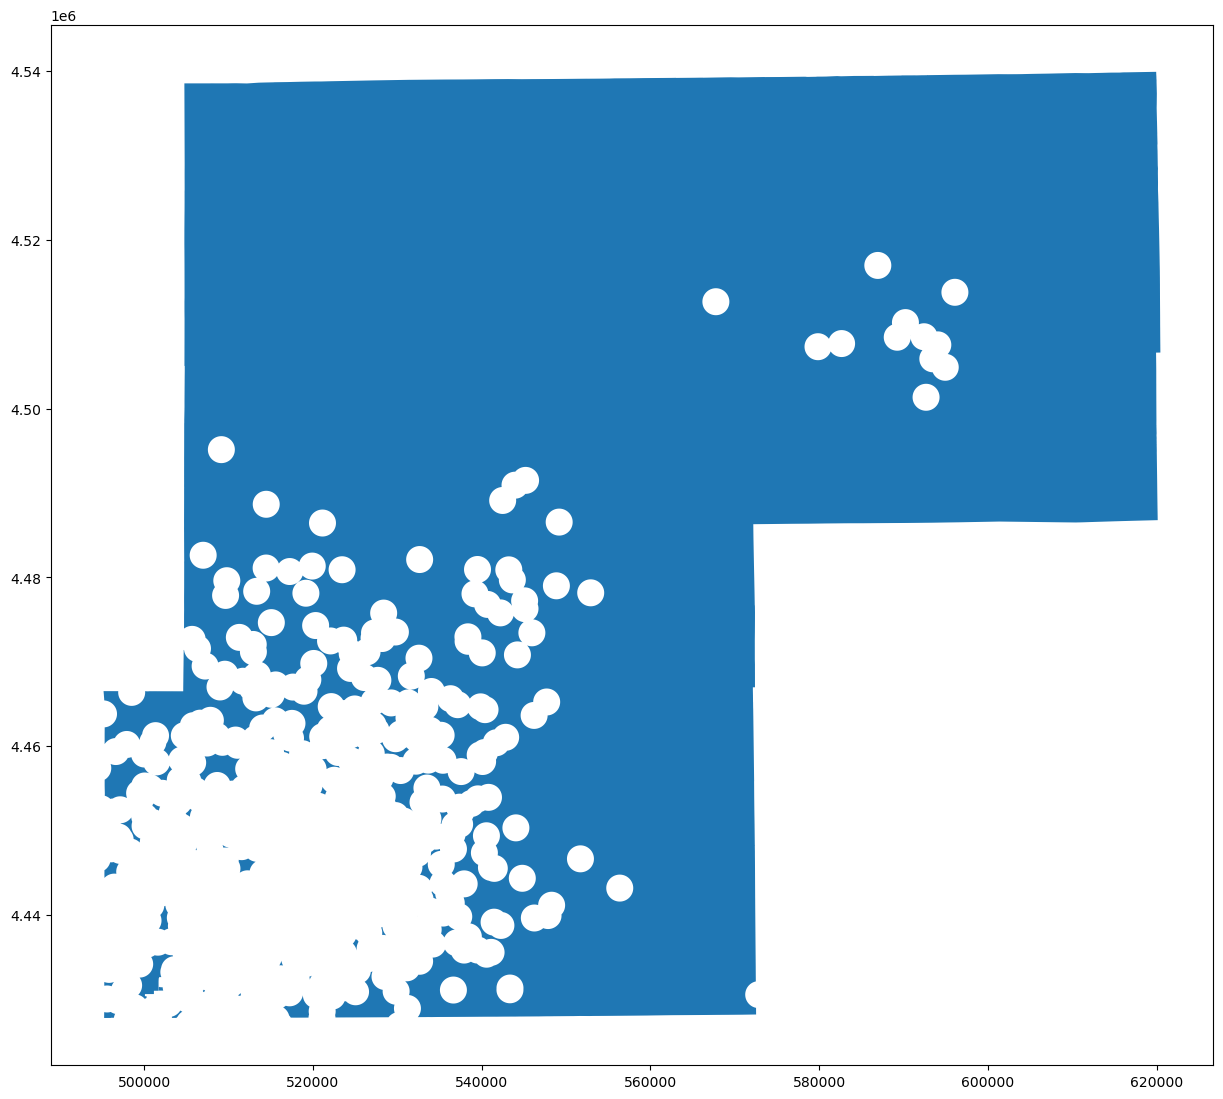

In [129]:
# Convert both dataframes to UTM coordinates
counties.to_crs(epsg = 26913, inplace = True)
raptors.to_crs(epsg = 26913, inplace = True)

# Create 1 mile buffers around raptors nests and set to default geometry
raptors['buffer'] = raptors['geometry'].buffer(1600)
raptors.set_geometry('buffer', inplace = True)

unimpacted_weld = gpd.overlay(counties[counties['NAMELSAD10'] == 'Weld County'],
                                raptors, how = 'difference')
unimpacted_weld.plot(figsize = (15, 15))
plt.show()

# Measurements

In [130]:
buowl = gpd.read_file(f"{fpath}/BUOWL_Habitat.shp")
raptors = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
linears = gpd.read_file(f"{fpath}/Linear_Projects.shp")

We need to convert to a projection suitable for calculating areas and lengths. EPSG:2163 is the US National Atlas equal area projection which covers the entire US. If the area is small enough, UTM zones will likely be more accurate.

In [131]:
buowl = buowl.to_crs(epsg = 2163)

# Create a new field showing the area calculated with crs = 2163
buowl['area_2163'] = buowl['geometry'].area / 10000
buowl.head(10)

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,area_2163
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((-392394.783 -526213.161, -392387.283...",2.624491
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((-395384.883 -528889.515, -395371.596...",0.030482
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((-391221.330 -532481.824, -391208.291...",0.053994
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((-398861.102 -524629.949, -398842.006...",0.030371
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((-397897.572 -522401.491, -397906.230...",12.419214
5,56.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,56,FALSE,"POLYGON ((-403026.638 -539741.928, -403000.523...",15.116806
6,58.0,Active Prarie Dog Colony,Undetermined,REMOVED,58,FALSE,"POLYGON ((-406764.506 -534641.037, -406518.088...",201.417404
7,72.0,Ground squirrel-mixed Vegetation,Undetermined,REMOVED,72,FALSE,"POLYGON ((-398465.398 -536299.344, -398400.269...",1.667002
8,79.0,Small Animal Burrows,Undetermined,REMOVED,79,FALSE,"POLYGON ((-403047.076 -535298.090, -402961.667...",2.058609
9,NaN,Active Prarie Dog Colony,None,NO NESTING ACTIVITY OBSERVED,125,FALSE,"POLYGON ((-392429.648 -551809.131, -392246.516...",70.310243


In [132]:
# Convert the GeoDataFrame to UTM Zone 13 coordinates
buowl = buowl.to_crs(epsg = 26913)

# Create a new field showing area when projected to UTM zone 13
buowl['area_26913'] = buowl['geometry'].area / 10000
buowl.head()

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,area_2163,area_26913
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((532623.735 4446446.455, 532633.250 4...",2.624491,2.625349
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((529788.307 4443598.828, 529801.958 4...",0.030482,0.030492
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((534158.801 4440267.446, 534171.559 4...",0.053994,0.054011
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((526066.346 4447636.411, 526085.954 4...",0.030371,0.030381
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((526901.098 4449915.854, 526893.505 4...",12.419214,12.423269


In [133]:
# Create a field showing the difference
buowl['area_diff'] = (buowl['area_26913'] - buowl['area_2163']) / buowl['area_2163'] * 100
buowl.describe()

,postgis_fi,habitat_id,area_2163,area_26913,area_diff
count,471.000000,473.000000,473.000000,473.000000,473.000000
mean,244.006369,244.334038,11.251870,11.255564,0.031651
std,142.293546,141.358371,22.658733,22.666463,0.006559
min,0.000000,1.000000,0.000047,0.000047,0.020466
25%,119.500000,122.000000,0.831897,0.832150,0.028710
50%,244.000000,243.000000,3.568499,3.569590,0.030685
75%,368.500000,368.000000,11.380359,11.383486,0.032655
max,487.000000,487.000000,267.995570,268.107448,0.092282


## Length and perimeter

In [134]:
buowl['perimeter'] = buowl['geometry'].length
buowl.head()

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,area_2163,area_26913,area_diff,perimeter
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((532623.735 4446446.455, 532633.250 4...",2.624491,2.625349,0.032687,1143.579682
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((529788.307 4443598.828, 529801.958 4...",0.030482,0.030492,0.031741,67.730172
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((534158.801 4440267.446, 534171.559 4...",0.053994,0.054011,0.031735,89.885589
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((526066.346 4447636.411, 526085.954 4...",0.030371,0.030381,0.032073,79.198961
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((526901.098 4449915.854, 526893.505 4...",12.419214,12.423269,0.032655,1477.209816


In [135]:
# Perimeter of circle
buowl['min_perimeter'] = (buowl['geometry'].area / math.pi)**0.5 * math.pi * 2
buowl.head()

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,area_2163,area_26913,area_diff,perimeter,min_perimeter
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((532623.735 4446446.455, 532633.250 4...",2.624491,2.625349,0.032687,1143.579682,574.378887
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((529788.307 4443598.828, 529801.958 4...",0.030482,0.030492,0.031741,67.730172,61.900966
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((534158.801 4440267.446, 534171.559 4...",0.053994,0.054011,0.031735,89.885589,82.384767
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((526066.346 4447636.411, 526085.954 4...",0.030371,0.030381,0.032073,79.198961,61.788416
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((526901.098 4449915.854, 526893.505 4...",12.419214,12.423269,0.032655,1477.209816,1249.461494


In [136]:
# Ratio of polygon perimeter to circle perimeter
buowl['perimeter_ratio'] = buowl['perimeter'] / buowl['min_perimeter']
buowl.head()

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,area_2163,area_26913,area_diff,perimeter,min_perimeter,perimeter_ratio
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((532623.735 4446446.455, 532633.250 4...",2.624491,2.625349,0.032687,1143.579682,574.378887,1.990985
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((529788.307 4443598.828, 529801.958 4...",0.030482,0.030492,0.031741,67.730172,61.900966,1.094170
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((534158.801 4440267.446, 534171.559 4...",0.053994,0.054011,0.031735,89.885589,82.384767,1.091046
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((526066.346 4447636.411, 526085.954 4...",0.030371,0.030381,0.032073,79.198961,61.788416,1.281777
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((526901.098 4449915.854, 526893.505 4...",12.419214,12.423269,0.032655,1477.209816,1249.461494,1.182277


In [137]:
buowl.sort_values('perimeter_ratio', ascending = False)

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,area_2163,area_26913,area_diff,perimeter,min_perimeter,perimeter_ratio
391,323.0,Animal Burrows,Undetermined,NO NESTING ACTIVITY OBSERVED,323,FALSE,"POLYGON ((531125.131 4449943.174, 531129.889 4...",0.130375,0.130418,0.033174,424.181217,128.018746,3.313430
446,384.0,Active Prairie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,384,FALSE,"POLYGON ((492945.101 4431526.402, 492945.945 4...",1.517436,1.517846,0.027016,1164.558749,436.735788,2.666506
191,87.0,Small Animal Burrows,Undetermined,NO NESTING ACTIVITY OBSERVED,87,FALSE,"POLYGON ((533196.942 4437863.465, 533199.259 4...",8.345791,8.348327,0.030394,2285.744131,1024.246911,2.231634
26,296.0,Abandoned Prairie Dog Colony,Undetermined,REMOVED,296,FALSE,"POLYGON ((518070.077 4452682.206, 518072.560 4...",0.005995,0.005997,0.032260,61.168636,27.450939,2.228289
456,399.0,Active Prairie Dog Colony,Undetermined,UNDETERMINED,399,FALSE,"POLYGON ((503770.936 4447134.014, 503814.359 4...",18.317158,18.322714,0.030337,3240.001572,1517.399158,2.135234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,76.0,Small Animal Burrows,Undetermined,UNDETERMINED,76,FALSE,"POLYGON ((529115.488 4451302.635, 529126.594 4...",1.936887,1.937531,0.033226,510.953831,493.434176,1.035506
468,447.0,Active Prairie Dog Colony,Yes,ACTIVE NEST,447,FALSE,"POLYGON ((550582.941 4479404.141, 550509.235 4...",2.868712,2.869954,0.043300,620.619822,600.540610,1.033435
256,163.0,Praire Dog Colony,Undetermined,UNDETERMINED,163,FALSE,"POLYGON ((519036.662 4446572.096, 519059.647 4...",0.483461,0.483611,0.031069,254.732951,246.520419,1.033314
417,354.0,Active Prairie Dog Colony,Undetermined,UNDETERMINED,354,FALSE,"POLYGON ((536366.489 4442663.015, 536318.775 4...",4.481343,4.482806,0.032627,772.471106,750.550438,1.029206


<AxesSubplot: >

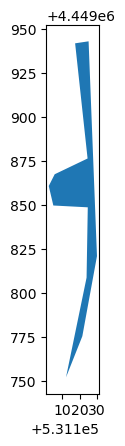

In [138]:
# Interesting
buowl[buowl['habitat_id']==323].plot()

In [139]:
linears.head()

,postgis_fi,type,row_width,Project,geometry
0,50,Flowline,20.0,50,"LINESTRING (-104.59795 40.19258, -104.59739 40..."
1,67,Pipeline,50.0,67,"LINESTRING (-105.05555 40.06609, -105.05941 40..."
2,68,Pipeline,50.0,68,"LINESTRING (-105.04607 40.10830, -105.04566 40..."
3,69,Flowline,20.0,69,"LINESTRING (-104.83998 40.21731, -104.83930 40..."
4,70,Flowline,20.0,70,"LINESTRING (-104.77210 40.20982, -104.77193 40..."


In [140]:
# Calculate length of some linear features
linears.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [141]:
linears['length'] = linears['geometry'].to_crs(epsg = 26913).length
linears

,postgis_fi,type,row_width,Project,geometry,length
0,50,Flowline,20.0,50,"LINESTRING (-104.59795 40.19258, -104.59739 40...",61.493007
1,67,Pipeline,50.0,67,"LINESTRING (-105.05555 40.06609, -105.05941 40...",1598.899548
2,68,Pipeline,50.0,68,"LINESTRING (-105.04607 40.10830, -105.04566 40...",944.785359
3,69,Flowline,20.0,69,"LINESTRING (-104.83998 40.21731, -104.83930 40...",258.978327
4,70,Flowline,20.0,70,"LINESTRING (-104.77210 40.20982, -104.77193 40...",254.149412
...,...,...,...,...,...,...
1104,1105,Flowline,20.0,1105,"LINESTRING (-104.76461 40.08340, -104.76410 40...",110.625879
1105,1106,Pipeline,50.0,1106,"LINESTRING (-104.88730 40.13059, -104.89431 40...",5980.267782
1106,1107,Pipeline,50.0,1107,"LINESTRING (-104.81084 40.13516, -104.80847 40...",5652.843524
1107,1108,Pipeline,50.0,1108,"LINESTRING (-104.85211 40.11728, -104.85257 40...",39.213896


In [142]:
raptors['area'] = raptors['geometry'].area
raptors['length'] = raptors['geometry'].length
raptors

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\4186699063.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  raptors['area'] = raptors['geometry'].area
C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\4186699063.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  raptors['length'] = raptors['geometry'].length


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,area,length
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891),0.0,0.0
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089),0.0,0.0
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694),0.0,0.0
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215),0.0,0.0
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571),0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297),0.0,0.0
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975),0.0,0.0
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432),0.0,0.0
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443),0.0,0.0


# Geometry Creation

## Buffering

Common method.

In [143]:
buowl = gpd.read_file(f"{fpath}/BUOWL_Habitat.shp")
raptors = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
linears = gpd.read_file(f"{fpath}/Linear_Projects.shp")
eagles = gpd.read_file(f"{fpath}/BAEA_Nests.shp")

In [144]:
# Reproject points of eagles to UTM so we can provide buffer distance in meters
eagles = eagles.to_crs(epsg = 26913)
eagles['buffer'] = eagles['geometry'].buffer(804.5) # 1/2 miles
eagles.head()

,postgis_fi,lat_y_dd,long_x_dd,status,nest_id,geometry,buffer
0,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (516703.700 4457307.158),"POLYGON ((517508.200 4457307.158, 517504.326 4..."
1,35,40.158003,-104.551141,INACTIVE LOCATION,35,POINT (538226.199 4445390.102),"POLYGON ((539030.699 4445390.102, 539026.825 4..."
2,36,39.929381,-104.970620,ACTIVE NEST,36,POINT (502510.499 4419919.328),"POLYGON ((503314.999 4419919.328, 503311.125 4..."
3,37,40.556888,-104.974663,ACTIVE NEST,37,POINT (502145.414 4489569.496),"POLYGON ((502949.914 4489569.496, 502946.041 4..."
4,46,40.055709,-105.014636,ACTIVE NEST,46,POINT (498751.412 4433940.343),"POLYGON ((499555.912 4433940.343, 499552.038 4..."


<AxesSubplot: >

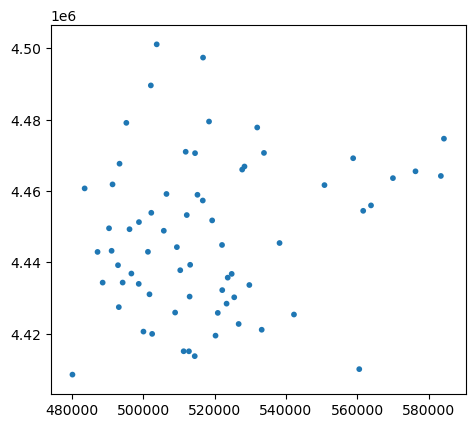

In [145]:
# Since we have two GeoDataSeries in our GDF, specify which we want to use
eagles.set_geometry('buffer', inplace = True)
eagles.plot()

<AxesSubplot: >

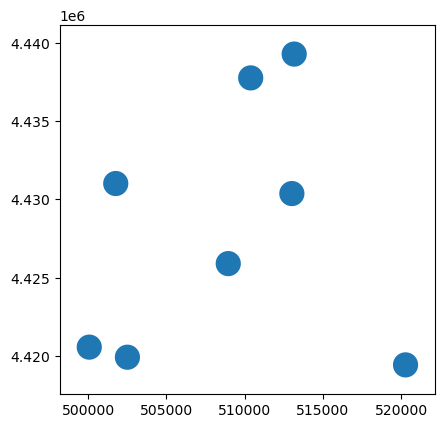

In [146]:
# Zoom in to see effect
eagles.cx[500000:520000,4420000:4440000].plot()

In [147]:
# Look at linears table, convert to UTM coordinates so we can use meters
linears.to_crs(epsg = 26913, inplace = True)
linears.tail()

,postgis_fi,type,row_width,Project,geometry
1104,1105,Flowline,20.0,1105,"LINESTRING (520068.356 4437040.055, 520111.683..."
1105,1106,Pipeline,50.0,1106,"LINESTRING (509601.718 4442257.339, 509004.478..."
1106,1107,Pipeline,50.0,1107,"LINESTRING (516114.783 4442775.612, 516316.688..."
1107,1108,Pipeline,50.0,1108,"LINESTRING (512602.246 4440784.416, 512563.046..."
1108,1109,Pipeline,50.0,1109,"LINESTRING (530292.107 4432618.710, 530249.454..."


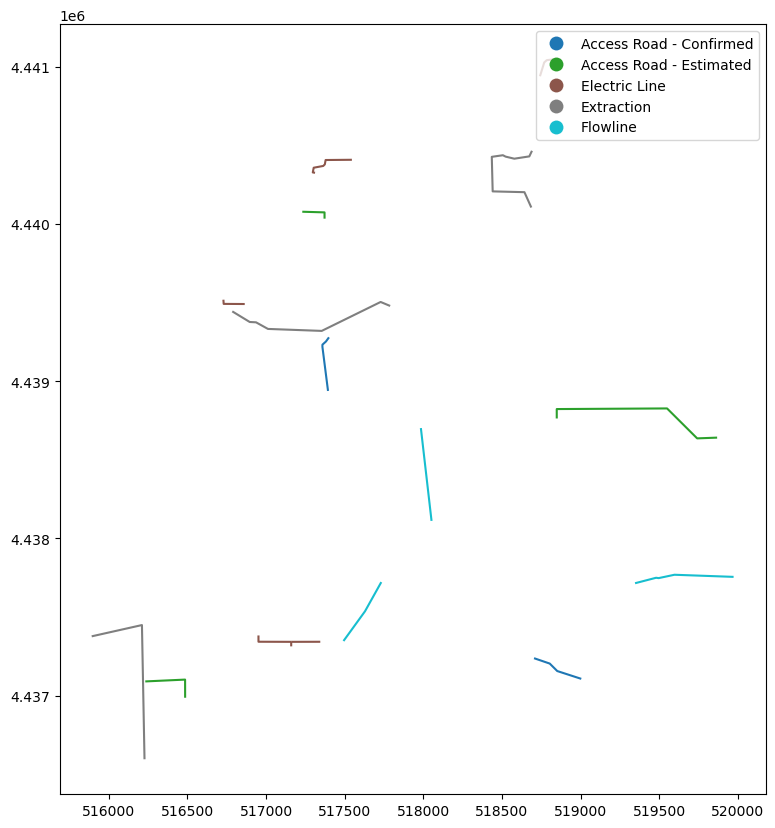

In [148]:
linears.cx[516000:520000, 4437000:4441000].plot(column = 'type', legend = True, figsize = (10, 10))
plt.show()

We can see that there are a number of linear projects. These are pipelines, electric lines, access roads, etc., associated with an oil and gas field in a region called the DJ Basin, north of Denver Colorado. The other layers represent wildlife species present and may impose environmental constraints on construction operations. Each linear project has a right-of-way around it. Thus, we need to create right-of-way polygons by buffering the linear projects by the appropriate distance.

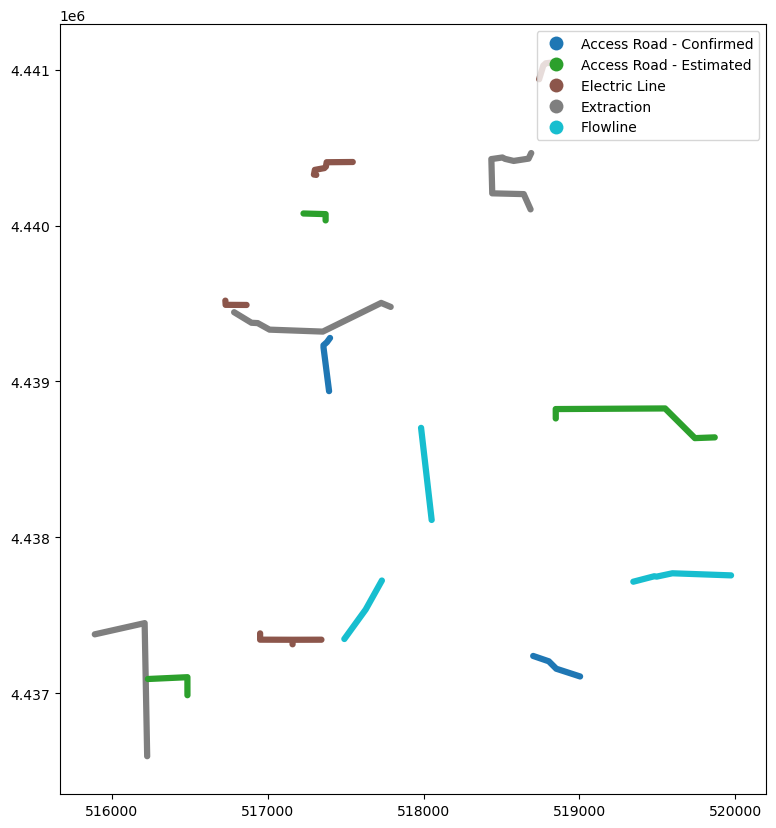

In [149]:
linears['buffer'] = linears['geometry'].buffer(linears['row_width'])

linears.set_geometry('buffer', inplace = True)
linears.cx[516000:520000, 4437000:4441000].plot(column = 'type', legend = True, figsize = (10, 10))
plt.show()

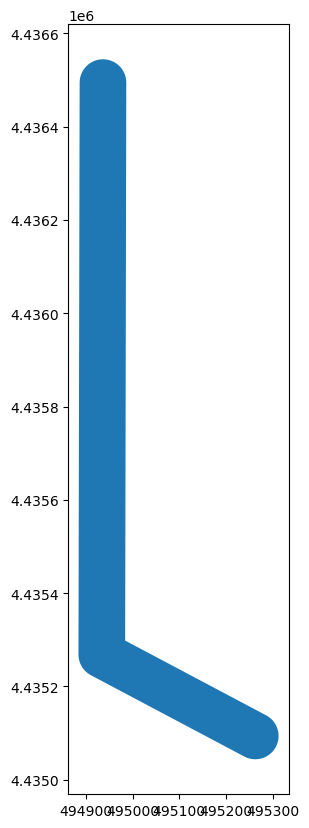

In [150]:
# Show that the distance is correct
linears[linears['Project'] == 67].plot(figsize = (10, 10))
plt.show()

In [151]:
linears[linears['Project'] == 67]

,postgis_fi,type,row_width,Project,geometry,buffer
1,67,Pipeline,50.0,67,"LINESTRING (495262.900 4435093.805, 494933.844...","POLYGON ((494910.422 4435224.098, 494906.185 4..."


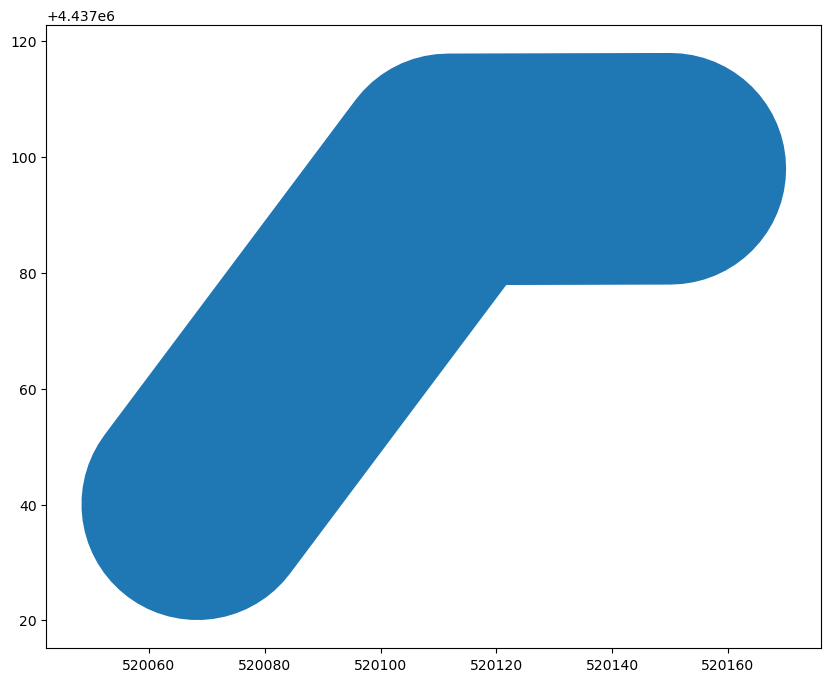

In [152]:
linears[linears['Project'] == 1105].plot(figsize = (10, 10))
plt.show()

In [153]:
linears[linears['Project'] == 1105]

,postgis_fi,type,row_width,Project,geometry,buffer
1104,1105,Flowline,20.0,1105,"LINESTRING (520068.356 4437040.055, 520111.683...","POLYGON ((520095.677 4437109.878, 520096.992 4..."


## Convex Hull

Convex hulls create a minimum convex polygon around a geometry. We'll assign these to a GeoSeries.

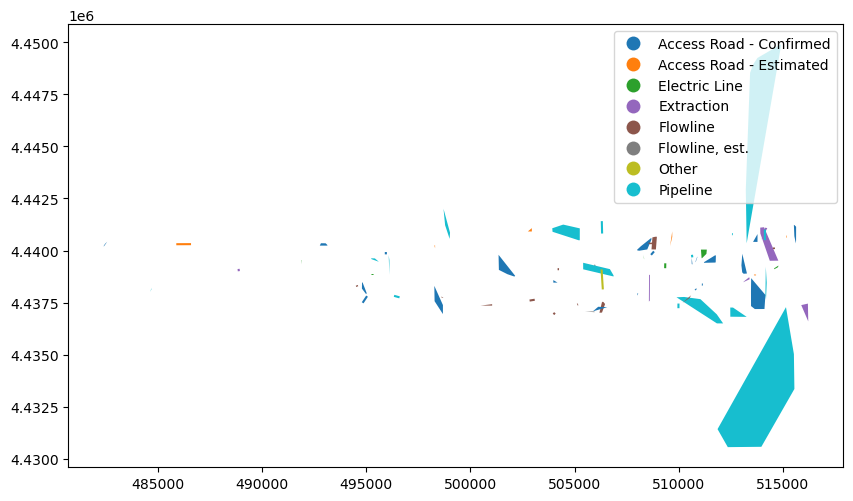

In [154]:
linears['mcp'] = linears['geometry'].convex_hull
linears.set_geometry('mcp', inplace = True)
linears.cx[516000:52000, 4437000:4441000].plot(column = 'type', legend = True, figsize = (10, 10))
plt.show()

## Envelope

This creates a bounding box for each geometry.

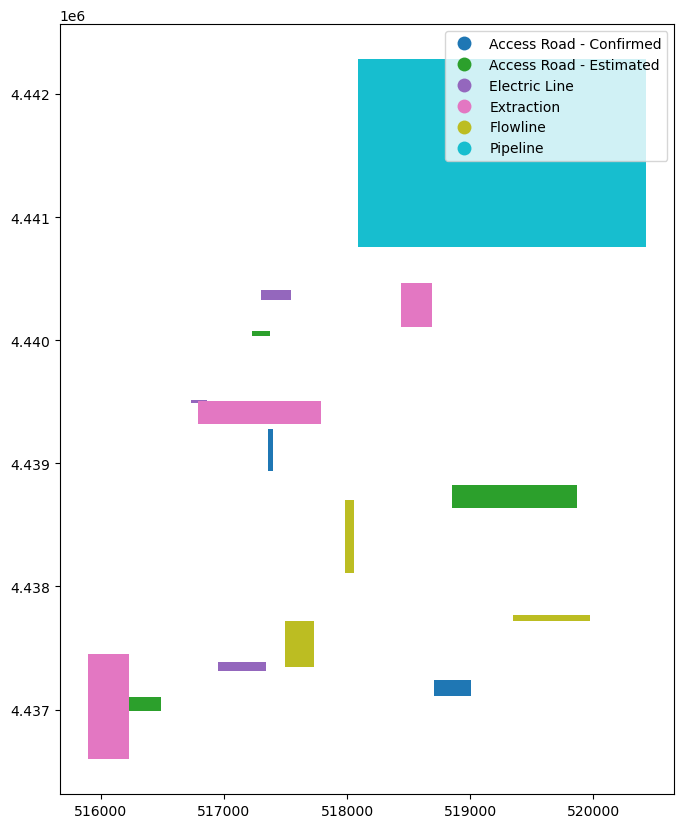

In [155]:
linears['bb'] = linears['geometry'].envelope
linears.set_geometry('bb', inplace = True)
linears.cx[516000:520000, 4437000:4441000].plot(column = 'type', legend = True, figsize = (10, 10))
plt.show()

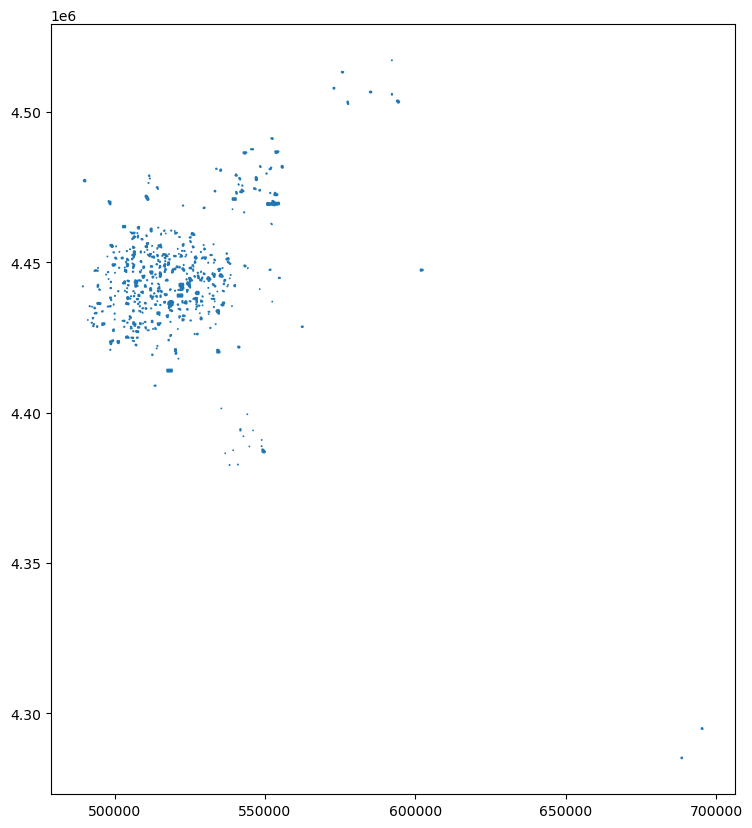

In [156]:
# Let's create buffers of 300m around the burrowing owl habitat
buowl.to_crs(epsg = 26913, inplace = True)
buowl['buffer'] = buowl['geometry'].buffer(300)
buowl.set_geometry('buffer').plot(figsize = (10, 10))
plt.show()

## Centroid

We can use this to create a point at the geometric center of the polygon. Note that the centroid is not guaranteed to actually be inside.

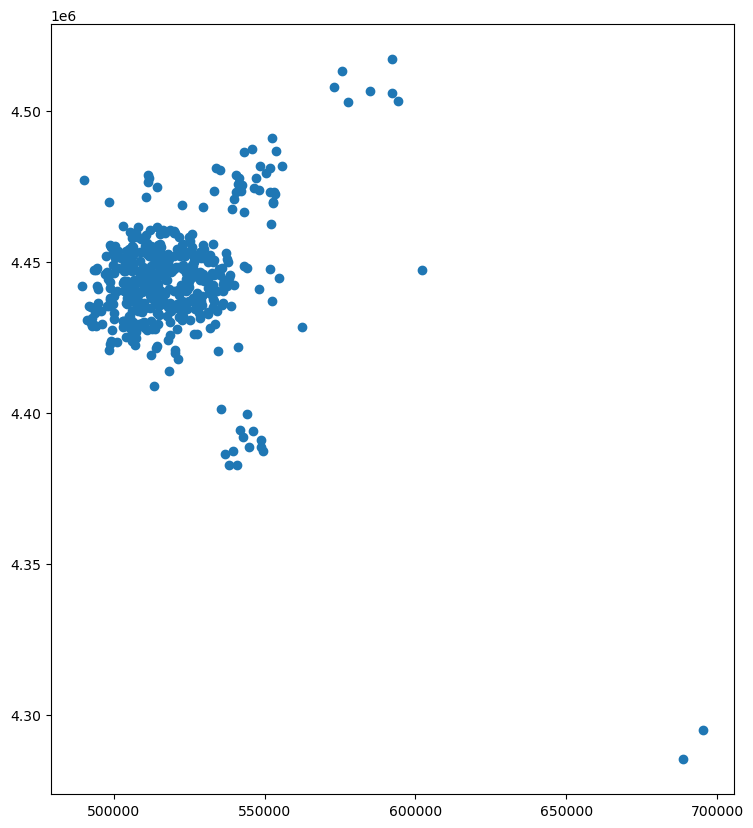

In [157]:
buowl['centroid'] = buowl['geometry'].centroid
buowl.set_geometry('centroid').plot(figsize = (10, 10))
plt.show()

# Apply, map, and str.replace methods

It's common to loop through a table and perform an operation on each record individually. However, we can apply a function to an entire series.

In [158]:
buowl = gpd.read_file(f"{fpath}/BUOWL_Habitat.shp")
raptors = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
linears = gpd.read_file(f"{fpath}/Linear_Projects.shp")
eagles = gpd.read_file(f"{fpath}/BAEA_Nests.shp")

In [159]:
# Create a field that contains the length (number of characters) of the recentstat field
raptors['stat_len'] = len(raptors['recentstat'])
raptors.head()
# Method 1: Loop for each row

ts = time.time()
for idx in raptors.index:
    raptors.at[idx, 'stat_len'] = len(raptors.at[idx, 'recentstat'])
te = time.time()

method1 = te - ts
print(f'Total Time: {method1:10.5f}')
raptors

Total Time:    0.17530


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891),13
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089),13
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694),13
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215),13
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571),11
...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297),13
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975),13
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432),13
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443),13


In [160]:
# Method 2: apply method
ts = time.time()
raptors['stat_len'] = raptors['recentstat'].apply(len)
te = time.time()

method2 = te - ts
print(f'Total Time: {method2:10.5f}')
print(method1/method2)
raptors.tail()

Total Time:    0.00184
95.30187945560596


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297),13
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975),13
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432),13
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443),13
878,NaN,40.243865,-104.937170,None,RTHA,FLEDGED NEST,1002,POINT (-104.93717 40.24387),12


In [161]:
# Method 3: Lambda
ts = time.time()
raptors['stat_len'] = raptors['recentstat'].apply(lambda x: int(len(x) / 2))
te = time.time()

method3 = te - ts
print(f'Total Time: {method3:10.5f}')
print(method1 / method3)
raptors.tail()

Total Time:    0.00200
87.81249253553088


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297),6
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975),6
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432),6
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443),6
878,NaN,40.243865,-104.937170,None,RTHA,FLEDGED NEST,1002,POINT (-104.93717 40.24387),6


In [162]:
# Method 4: Writing our own customer function
def return_len(s):
    return len(s)

ts = time.time()
raptors['stat_len'] = raptors['recentstat'].apply(return_len)
te = time.time()

method4 = te - ts
print(f'Total Time: {method4:10.5f}')
print(method1 / method4)

Total Time:    0.00230
76.32658569500674


We are doing this because we want to create buffers for the raptor points, but buffers will vary according to species. For Swainson Hawks, buffer distance will be 333 meters, but the rest will be 667 meters.

In [163]:
# Convert raptors GeoDataFrame to UTM coordinates
raptors.to_crs(epsg = 26913, inplace = True)
raptors.head()

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),13
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),13
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (456319.858 4282156.305),13
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (512832.261 4466854.171),13
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),11


In [164]:
# Create a new column that will hold distance we will buffer the point by
ts = time.time()
raptors['buf_dist'] = raptors['recentspec'].apply(lambda s: 333 if s == 'Swainsons Hawk' else 667)
te = time.time()

method = te - ts
print(f'Total Time: {method:10.5f}')
raptors

Total Time:    0.00100


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len,buf_dist
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),13,333
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),13,333
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (456319.858 4282156.305),13,333
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (512832.261 4466854.171),13,333
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),11,333
...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (501370.881 4428086.730),13,667
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (513009.440 4424410.603),13,667
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),13,667
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (504676.732 4454887.748),13,667


In [165]:
# This works, but is confusing and limited
# Write our own custom function instead

def calc_raptor_buffer(spec):
    if spec == 'Swainsons Hawk':
        return 333
    elif spec == 'Northern Harrier':
        return 500
    else:
        return 667

ts = time.time()
raptors['buf_dist'] = raptors['recentspec'].apply(calc_raptor_buffer)
te = time.time()

method = te - ts
print(f'Total Time: {method:10.5f}')
raptors

Total Time:    0.00094


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len,buf_dist
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),13,333
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),13,333
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (456319.858 4282156.305),13,333
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (512832.261 4466854.171),13,333
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),11,333
...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (501370.881 4428086.730),13,667
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (513009.440 4424410.603),13,667
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),13,500
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (504676.732 4454887.748),13,667


Another method that can be used is map, taking a dictionary as a parameter and returns the value when a key match is found.

In [166]:
species_buffer = {'Swainsons Hawk': 333, 'Red-tail Hawk': 667, 'Northern Harrier': 500}

# Map a buffer distance value
ts = time.time()
raptors['buf_dist2'] = raptors['recentspec'].map(species_buffer)
te = time.time()

method = te - ts
print(f'Total Time: {method:10.5f}')
raptors

Total Time:    0.00372


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len,buf_dist,buf_dist2
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),13,333,333.0
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),13,333,333.0
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (456319.858 4282156.305),13,333,333.0
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (512832.261 4466854.171),13,333,333.0
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),11,333,333.0
...,...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (501370.881 4428086.730),13,667,667.0
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (513009.440 4424410.603),13,667,667.0
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),13,500,500.0
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (504676.732 4454887.748),13,667,NaN


The last two values are NaN, so they didn't match any key in the dictionary. We can set a default value using a dictionary.

In [167]:
species_buffer = defaultdict(lambda: 1000,
                            {
                                'Swainsons Hawk': 333,
                                'Red-tail Hawk': 667,
                                'Northern Harrier': 500
                            })

ts = time.time()
raptors['buf_dist'] = raptors['recentspec'].map(species_buffer)
te = time.time()

method = te - ts
print(f'Total Time: {method:10.5f}')
raptors

Total Time:    0.00100


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len,buf_dist,buf_dist2
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),13,333,333.0
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),13,333,333.0
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (456319.858 4282156.305),13,333,333.0
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (512832.261 4466854.171),13,333,333.0
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),11,333,333.0
...,...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (501370.881 4428086.730),13,667,667.0
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (513009.440 4424410.603),13,667,667.0
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),13,500,500.0
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (504676.732 4454887.748),13,1000,NaN


SWHA and RTHA have a buffer distance of 1000. But really, we don't want them in the recentspec. They are misnamed.

In [168]:
raptors['recentspec'].unique()

array(['Swainsons Hawk', 'Red-tail Hawk', 'Northern Harrier', 'SWHA',
       'RTHA'], dtype=object)

In [169]:
raptors['recentspec'] = raptors['recentspec'].replace({'SWHA': 'Swainsons Hawk',
                                                            'RTHA': 'Red-tail Hawk'})

raptors.tail()

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len,buf_dist,buf_dist2
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (501370.881 4428086.730),13,667,667.0
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (513009.440 4424410.603),13,667,667.0
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),13,500,500.0
877,NaN,NaN,NaN,2020-05-05,Swainsons Hawk,INACTIVE NEST,1001,POINT (504676.732 4454887.748),13,1000,NaN
878,NaN,40.243865,-104.937170,None,Red-tail Hawk,FLEDGED NEST,1002,POINT (505344.097 4454825.953),12,1000,NaN


In [170]:
raptors['buf_dist'] = raptors['recentspec'].map(species_buffer)
raptors

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,stat_len,buf_dist,buf_dist2
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),13,333,333.0
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),13,333,333.0
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (456319.858 4282156.305),13,333,333.0
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (512832.261 4466854.171),13,333,333.0
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),11,333,333.0
...,...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (501370.881 4428086.730),13,667,667.0
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (513009.440 4424410.603),13,667,667.0
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),13,500,500.0
877,NaN,NaN,NaN,2020-05-05,Swainsons Hawk,INACTIVE NEST,1001,POINT (504676.732 4454887.748),13,333,NaN


# Overlay Operations

In [171]:
# Read data
buowl = gpd.read_file(f"{fpath}/BUOWL_Habitat.shp")
raptor = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
linear = gpd.read_file(f"{fpath}/Linear_Projects.shp")
eagle = gpd.read_file(f"{fpath}/BAEA_Nests.shp")
counties = gpd.read_file(f"{fpath}/colorado_counties.shp", mask = eagle)

# Clean raptor data
raptor = raptor.cx[:-104.3, 39.5:40.6]

# Convert raw data to UTM NAD83
for data in [buowl, raptor, linear, eagle, counties]:
    data.to_crs(epsg = 26913, inplace = True)

# Replace coded field values
raptor['recentspec'] = raptor['recentspec'].replace({'SWHA': 'Swainsons Hawk',
                                                    'RTHA': 'Red-tail Hawk'})
print('recentspec values = ', raptor['recentspec'].unique())

# Add buff_dist field to raptors GeoDataFrame
species_buffer = {'Swainsons Hawk': 333, 'Red-tail Hawk': 667, 'Northern Harrier': 500}
raptor['buf_dist'] = raptor['recentspec'].map(species_buffer)

# Add length field to linears
linear['length_m'] = linear['geometry'].length

# Create buffers
eagle['buffer'] = eagle['geometry'].buffer(804.5)
buowl['buffer'] = buowl['geometry'].buffer(300)
linear['buffer'] = linear['geometry'].buffer(linear['row_width'])
raptor['buffer'] = raptor['geometry'].buffer(raptor['buf_dist'])

for data in [eagle, buowl, linear, raptor]:
    data.set_geometry('buffer', inplace = True)

raptor

recentspec values =  ['Swainsons Hawk' 'Red-tail Hawk' 'Northern Harrier']


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,buf_dist,buffer
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),333,"POLYGON ((517674.522 4460953.719, 517672.919 4..."
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),333,"POLYGON ((518288.324 4452295.260, 518286.721 4..."
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (512832.261 4466854.171),333,"POLYGON ((513165.261 4466854.171, 513163.658 4..."
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),333,"POLYGON ((522069.624 4448400.393, 522068.020 4..."
5,4.0,40.217638,-104.779386,2011-01-06,Red-tail Hawk,FLEDGED NEST,4,POINT (517064.285 4445215.102),667,"POLYGON ((517731.285 4445215.102, 517728.073 4..."
...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (501370.881 4428086.730),667,"POLYGON ((502037.881 4428086.730, 502034.669 4..."
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (513009.440 4424410.603),667,"POLYGON ((513676.440 4424410.603, 513673.229 4..."
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),500,"POLYGON ((504719.463 4454875.391, 504717.056 4..."
877,NaN,NaN,NaN,2020-05-05,Swainsons Hawk,INACTIVE NEST,1001,POINT (504676.732 4454887.748),333,"POLYGON ((505009.732 4454887.748, 505008.128 4..."


## Simple plotting of more than 1 GDF

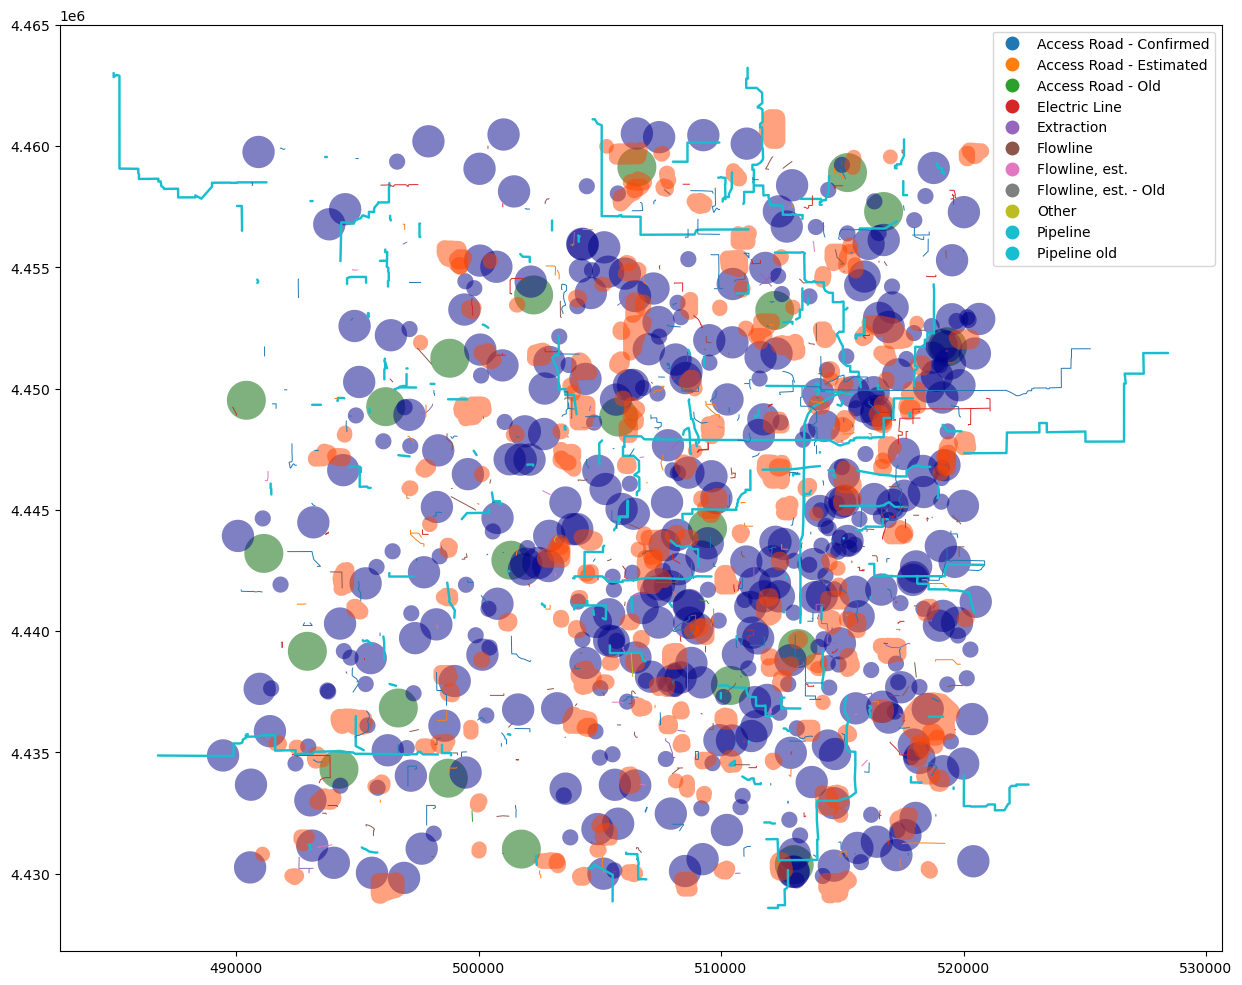

In [172]:
basemap = eagle.cx[490000:520000, 4430000:4460000].plot(color = 'darkgreen', alpha = 0.5, figsize = (15, 15))
basemap = raptor.cx[490000:520000, 4430000:4460000].plot(ax = basemap, color = 'darkblue', alpha = 0.5)
basemap = buowl.cx[490000:520000, 4430000:4460000].plot(ax = basemap, color = 'orangered', alpha = 0.5)
basemap = linear.cx[490000:520000, 4430000:4460000].plot(ax = basemap, cmap = 'tab10', column = 'type', legend = True)
plt.show()

In [173]:
linear.cx[490000:520000, 4430000:4460000].sort_values('length_m', ascending = False).head()

,postgis_fi,type,row_width,Project,geometry,length_m,buffer
299,295,Access Road - Confirmed,20.0,295,"LINESTRING (525231.405 4451647.877, 524451.963...",17113.355664,"POLYGON ((513275.114 4449272.162, 513274.167 4..."
300,296,Pipeline,50.0,296,"LINESTRING (506528.336 4445607.164, 506529.077...",17105.892046,"POLYGON ((505926.201 4447206.342, 505924.749 4..."
99,87,Pipeline,50.0,87,"LINESTRING (520031.747 4447340.131, 521767.739...",14108.343669,"POLYGON ((521719.034 4447399.107, 521740.018 4..."
638,636,Pipeline,50.0,636,"LINESTRING (498323.468 4434917.145, 497700.077...",13382.066319,"POLYGON ((490455.076 4435602.883, 490454.909 4..."
258,254,Pipeline,50.0,254,"LINESTRING (484951.194 4463017.764, 484951.719...",11924.202196,"POLYGON ((485001.415 4462949.713, 485049.615 4..."


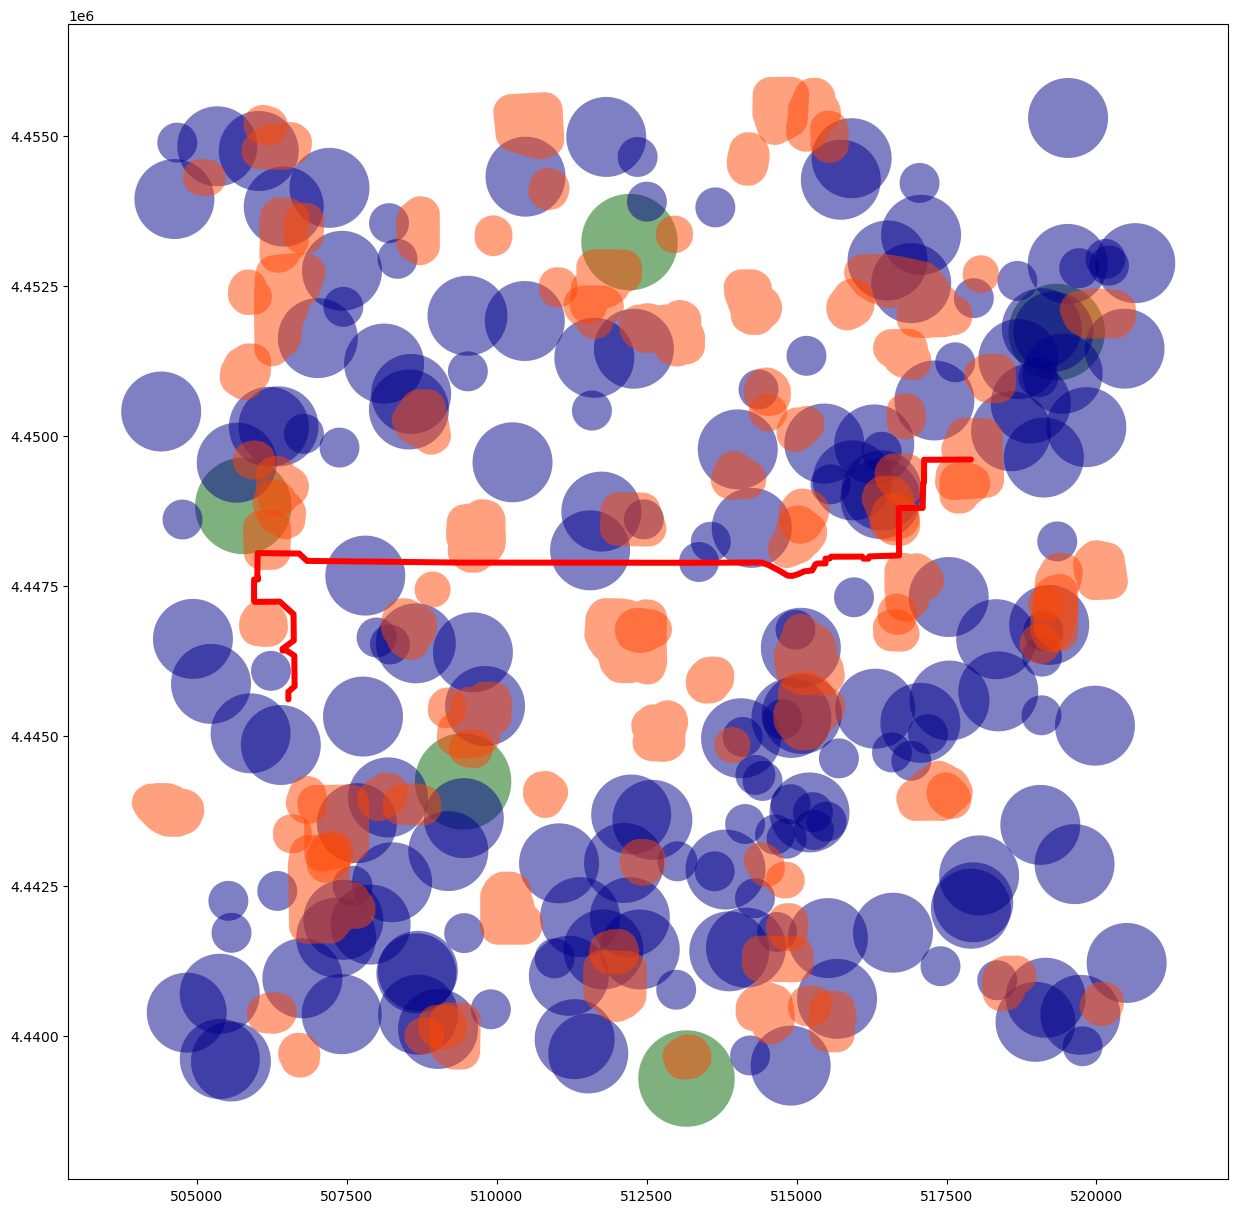

In [174]:
basemap = eagle.cx[505000:520000, 4440000:4455000].plot(color = 'darkgreen', alpha = 0.5, figsize = (15, 15))
basemap = raptor.cx[505000:520000, 4440000:4455000].plot(ax = basemap, color = 'darkblue', alpha = 0.5)
basemap = buowl.cx[505000:520000, 4440000:4455000].plot(ax = basemap, color = 'orangered', alpha = 0.5)
basemap = linear[linear['Project'] == 296].plot(ax = basemap, color = 'red')
plt.show()

## Different uses of intersections

In [175]:
# intersects - spatial predicate
linear_296 = linear[linear['Project'] == 296].unary_union
impacted_raptors = raptor[raptor['buffer'].intersects(linear_296)]
impacted_raptors

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,buf_dist,buffer
146,140.0,40.168164,-104.889043,2009-09-21,Red-tail Hawk,ACTIVE NEST,140,POINT (514252.859 4448465.844),667,"POLYGON ((514919.859 4448465.844, 514916.648 4..."
397,402.0,40.203174,-104.808378,2012-04-24,Red-tail Hawk,ACTIVE NEST,402,POINT (516398.732 4448946.352),667,"POLYGON ((517065.732 4448946.352, 517062.520 4..."
410,415.0,40.220341,-104.897814,2014-07-23,Red-tail Hawk,ACTIVE NEST,415,POINT (511558.303 4448090.533),667,"POLYGON ((512225.303 4448090.533, 512222.091 4..."
563,579.0,40.176497,-104.753992,2008-06-03,Swainsons Hawk,ACTIVE NEST,579,POINT (513570.552 4448234.833),333,"POLYGON ((513903.552 4448234.833, 513901.949 4..."
610,643.0,40.119125,-104.867317,2014-03-14,Swainsons Hawk,ACTIVE NEST,643,POINT (513373.650 4447895.952),333,"POLYGON ((513706.650 4447895.952, 513705.046 4..."
814,851.0,40.145773,-104.841214,2015-06-12,Red-tail Hawk,FLEDGED NEST,851,POINT (507811.257 4447669.519),667,"POLYGON ((508478.257 4447669.519, 508475.045 4..."
830,867.0,40.154771,-104.832801,2015-05-13,Red-tail Hawk,ACTIVE NEST,867,POINT (516417.148 4449089.574),667,"POLYGON ((517084.148 4449089.574, 517080.936 4..."


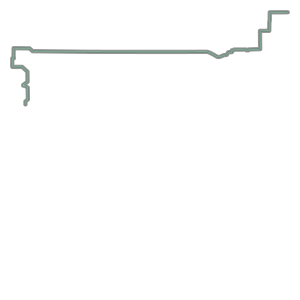

In [176]:
linear_296

In [177]:
# intersection - spatial operation
impacted_raptors['impacted_poly'] = impacted_raptors['buffer'].intersection(linear_296)
impacted_raptors['impacted_area'] = impacted_raptors['impacted_poly'].area / 10000
impacted_raptors

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,buf_dist,buffer,impacted_poly,impacted_area
146,140.0,40.168164,-104.889043,2009-09-21,Red-tail Hawk,ACTIVE NEST,140,POINT (514252.859 4448465.844),667,"POLYGON ((514919.859 4448465.844, 514916.648 4...","POLYGON ((514567.281 4447877.602, 514508.109 4...",5.879832
397,402.0,40.203174,-104.808378,2012-04-24,Red-tail Hawk,ACTIVE NEST,402,POINT (516398.732 4448946.352),667,"POLYGON ((517065.732 4448946.352, 517062.520 4...","POLYGON ((517062.520 4448880.975, 517052.916 4...",7.929815
410,415.0,40.220341,-104.897814,2014-07-23,Red-tail Hawk,ACTIVE NEST,415,POINT (511558.303 4448090.533),667,"POLYGON ((512225.303 4448090.533, 512222.091 4...","POLYGON ((512196.582 4447896.913, 512174.531 4...",12.663280
563,579.0,40.176497,-104.753992,2008-06-03,Swainsons Hawk,ACTIVE NEST,579,POINT (513570.552 4448234.833),333,"POLYGON ((513903.552 4448234.833, 513901.949 4...","POLYGON ((513697.986 4447927.181, 513667.217 4...",0.634405
610,643.0,40.119125,-104.867317,2014-03-14,Swainsons Hawk,ACTIVE NEST,643,POINT (513373.650 4447895.952),333,"POLYGON ((513706.650 4447895.952, 513705.046 4...","POLYGON ((513705.046 4447863.312, 513700.891 4...",6.625508
814,851.0,40.145773,-104.841214,2015-06-12,Red-tail Hawk,FLEDGED NEST,851,POINT (507811.257 4447669.519),667,"POLYGON ((508478.257 4447669.519, 508475.045 4...","POLYGON ((507172.978 4447863.139, 507195.029 4...",12.461285
830,867.0,40.154771,-104.832801,2015-05-13,Red-tail Hawk,ACTIVE NEST,867,POINT (516417.148 4449089.574),667,"POLYGON ((517084.148 4449089.574, 517080.936 4...","MULTIPOLYGON (((517080.936 4449024.197, 517071...",6.738611


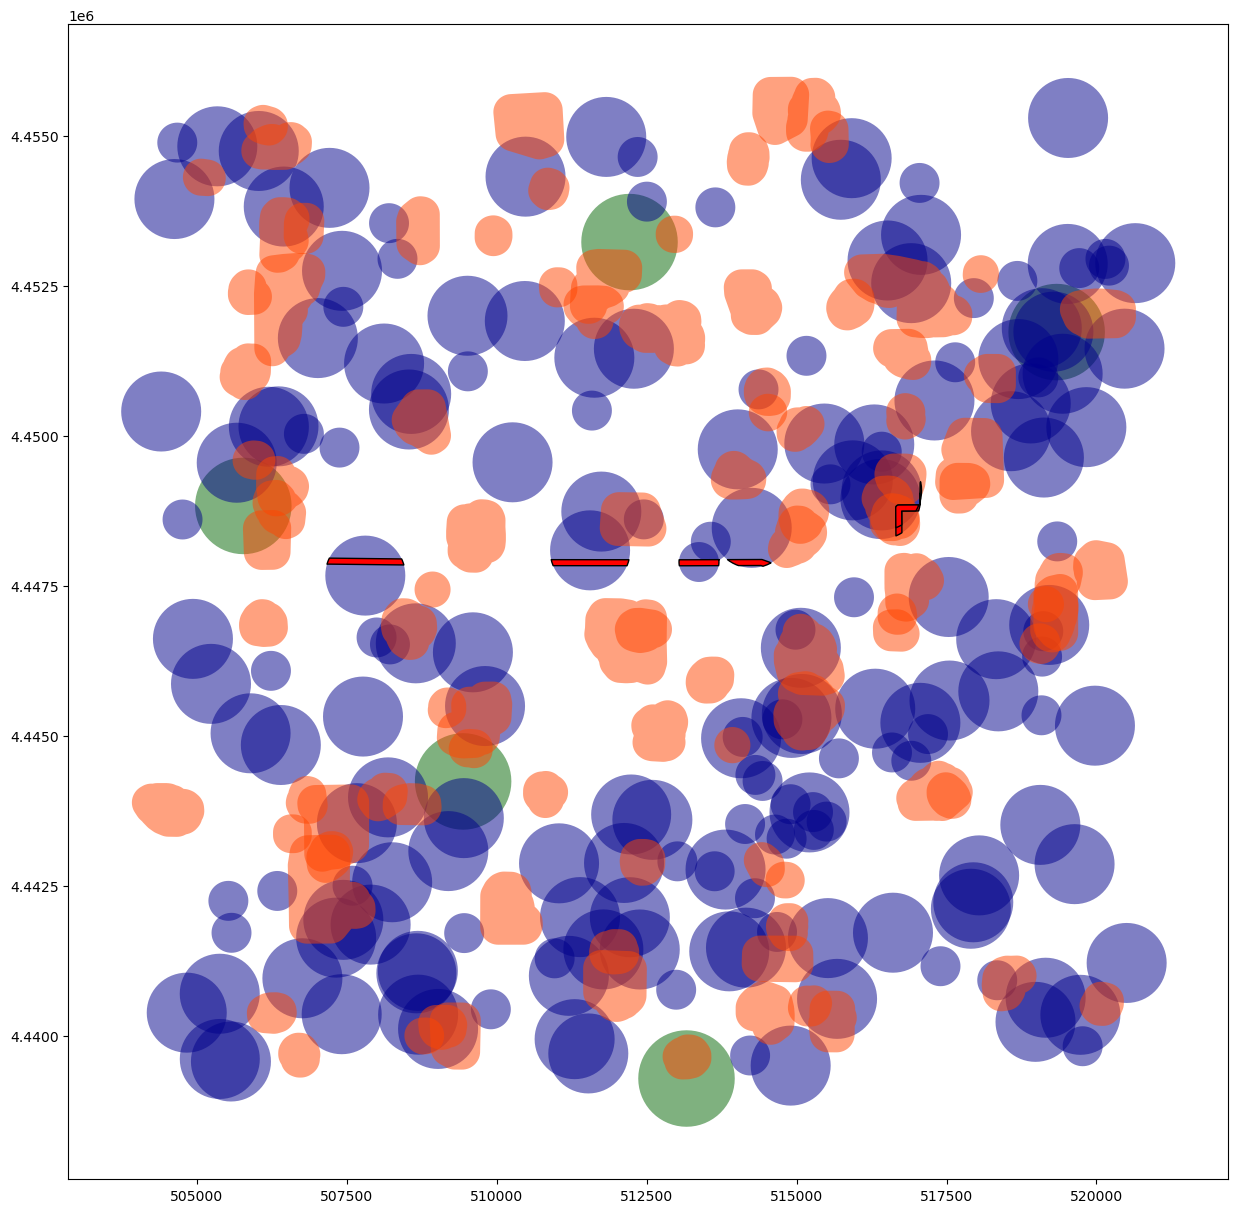

In [178]:
basemap = eagle.cx[505000:520000, 4440000:4455000].plot(color = 'darkgreen', alpha = 0.5, figsize = (15, 15))
basemap = raptor.cx[505000:520000, 4440000:4455000].plot(ax = basemap, color = 'darkblue', alpha = 0.5)
basemap = buowl.cx[505000:520000, 4440000:4455000].plot(ax = basemap, color = 'orangered', alpha = 0.5)
basemap = impacted_raptors.set_geometry('impacted_poly').plot(ax = basemap, color = 'red', edgecolor = 'k')

plt.show()

In [179]:
impacted_raptors[impacted_raptors['recentstat'] == 'ACTIVE NEST']['impacted_area'].max()

12.663279741425235

In [180]:
# Overlay method with how = 'intersection'
raptor_intersection = gpd.overlay(raptor, linear, how = 'intersection')
raptor_intersection['area_ha'] = raptor_intersection['geometry'].area / 1000
raptor_intersection

,postgis_fi_1,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry_1,buf_dist,postgis_fi_2,type,row_width,Project,geometry_2,length_m,geometry,area_ha
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (517341.522 4460953.719),333,1003,Pipeline,50.0,1003,"LINESTRING (517011.998 4461606.739, 517012.890...",1359.174276,"POLYGON ((517244.858 4460635.058, 517214.089 4...",52.653777
1,219.0,40.247995,-104.709889,2011-04-06,Red-tail Hawk,INACTIVE NEST,219,POINT (516872.918 4461478.780),667,1003,Pipeline,50.0,1003,"LINESTRING (517011.998 4461606.739, 517012.890...",1359.174276,"POLYGON ((517128.168 4460862.553, 517066.538 4...",80.678188
2,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (517955.324 4452295.260),333,977,Flowline,20.0,977,"LINESTRING (518143.078 4452413.362, 518415.345...",272.268063,"POLYGON ((518262.976 4452422.693, 518273.548 4...",5.553403
3,511.0,40.181594,-104.734128,2013-06-05,Swainsons Hawk,ACTIVE NEST,511,POINT (518681.238 4452582.276),333,977,Flowline,20.0,977,"LINESTRING (518143.078 4452413.362, 518415.345...",272.268063,"POLYGON ((518404.358 4452397.271, 518387.558 4...",1.437528
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (521736.624 4448400.393),333,87,Pipeline,50.0,87,"LINESTRING (520031.747 4447340.131, 521767.739...",14108.343669,"POLYGON ((522030.303 4448243.418, 522013.503 4...",32.055124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,906.0,40.051193,-104.794308,2015-08-17,Red-tail Hawk,INACTIVE NEST,906,POINT (520354.888 4436377.084),667,1049,"Flowline, est.",20.0,1049,"LINESTRING (519711.019 4436426.443, 519776.278...",187.997978,"POLYGON ((519795.625 4436255.205, 519796.029 4...",8.774539
843,907.0,39.995541,-104.891149,2015-08-18,Red-tail Hawk,INACTIVE NEST,907,POINT (515620.892 4431063.820),667,415,Access Road - Confirmed,20.0,415,"LINESTRING (514945.245 4431008.078, 514946.393...",385.640073,"POLYGON ((514957.104 4430998.442, 514953.892 4...",1.572473
844,907.0,39.995541,-104.891149,2015-08-18,Red-tail Hawk,INACTIVE NEST,907,POINT (515620.892 4431063.820),667,591,Access Road - Confirmed,20.0,591,"LINESTRING (515526.716 4430802.799, 515526.651...",32.187286,"POLYGON ((515506.743 4430836.905, 515507.027 4...",2.542111
845,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (504219.463 4454875.391),500,468,Access Road - Confirmed,20.0,468,"LINESTRING (504511.448 4454687.201, 504428.949...",83.107770,"POLYGON ((504429.407 4454657.168, 504427.445 4...",4.578930


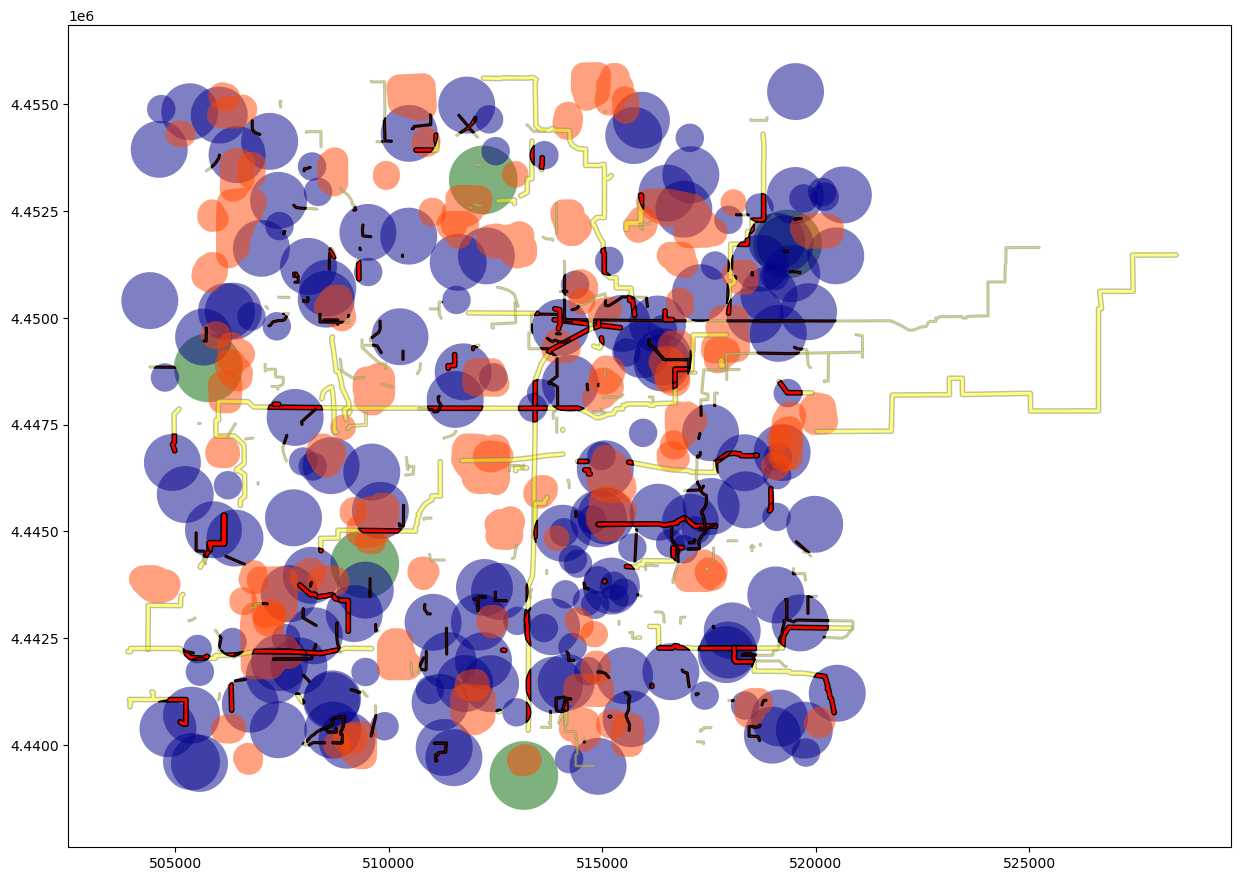

In [181]:
basemap = eagle.cx[505000:520000, 4440000:4455000].plot(color='darkgreen', alpha = 0.5, figsize=(15, 15))
basemap = raptor.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='darkblue', alpha = 0.5)
basemap = buowl.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='orangered', alpha = 0.5)
basemap = linear.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='yellow', alpha = 0.5, edgecolor='grey')
basemap = raptor_intersection.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='red', edgecolor='k')

plt.show()

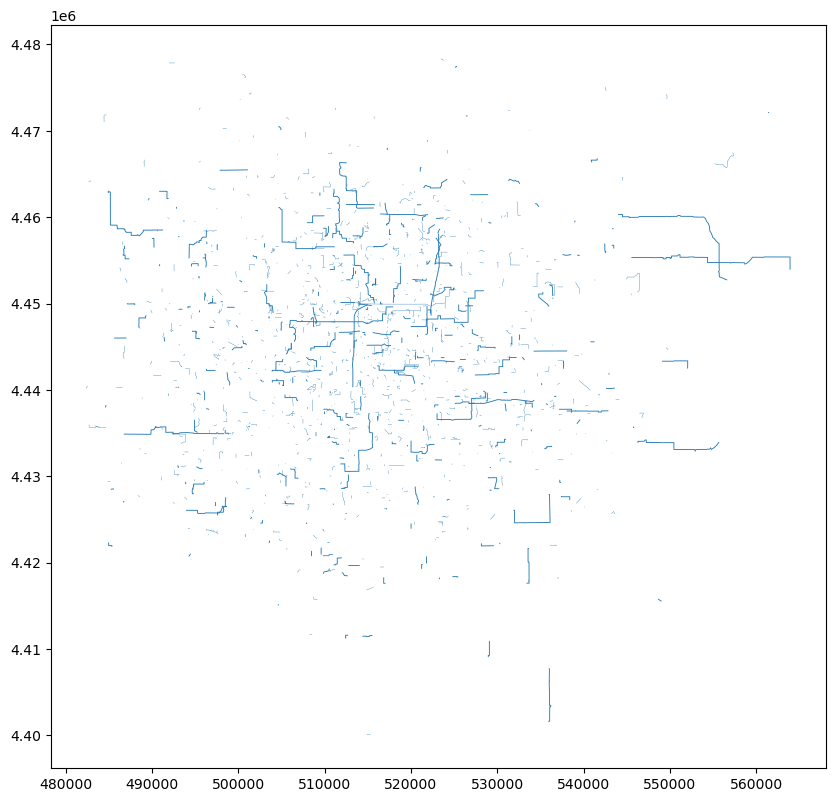

In [182]:
# Intersections with different geometry types
# Ex. Intersection with the raptor nest buffers and linear features
# Allowing us to know how many meters of a pipeline are impacted

linear.cx[:, 4400000:4480000].plot(figsize = (10, 10))
plt.show()

In [183]:
raptor_intersection_linear = gpd.overlay(linear, raptor, how='intersection')
raptor_intersection_linear['length_intersection'] = raptor_intersection_linear['geometry'].length
raptor_intersection_linear.sort_values('Project')

,postgis_fi_1,type,row_width,Project,geometry_1,length_m,postgis_fi_2,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry_2,buf_dist,geometry,length_intersection
81,2,Pipeline,50.0,2,"LINESTRING (522245.549 4451054.650, 522285.342...",2060.846957,601.0,40.212003,-104.735018,2014-06-11,Swainsons Hawk,ACTIVE NEST,601,POINT (523747.246 4451963.837),333,"POLYGON ((523899.788 4451669.209, 523903.612 4...",58.054911
87,3,Electric Line,20.0,3,"LINESTRING (516975.474 4435420.912, 516972.945...",1226.907371,544.0,40.080478,-104.765846,2014-06-26,Red-tail Hawk,ACTIVE NEST,544,POINT (517950.385 4435324.369),667,"MULTIPOLYGON (((517715.423 4434917.630, 517716...",1196.469111
88,3,Electric Line,20.0,3,"LINESTRING (516975.474 4435420.912, 516972.945...",1226.907371,826.0,40.098223,-104.788769,2015-06-23,Swainsons Hawk,FLEDGED NEST,826,POINT (517839.897 4434803.557),333,"POLYGON ((517715.423 4434917.630, 517716.364 4...",906.330390
85,3,Electric Line,20.0,3,"LINESTRING (516975.474 4435420.912, 516972.945...",1226.907371,87.0,40.046409,-104.830121,2008-04-25,Red-tail Hawk,INACTIVE NEST,87,POINT (518178.536 4434773.282),667,"POLYGON ((517715.423 4434917.630, 517716.364 4...",900.052070
89,4,Pipeline,50.0,4,"MULTILINESTRING ((529166.081 4438606.833, 5285...",11133.427929,285.0,40.155977,-104.637058,2011-08-02,Swainsons Hawk,ACTIVE NEST,285,POINT (529834.914 4438683.801),333,"POLYGON ((530003.051 4438911.098, 530008.218 4...",1480.127195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,1107,Pipeline,50.0,1107,"LINESTRING (516114.783 4442775.612, 516316.688...",5652.843524,211.0,40.122824,-104.709241,2011-04-06,Red-tail Hawk,INACTIVE NEST,211,POINT (517906.215 4442115.892),667,"POLYGON ((518541.427 4442318.084, 518544.494 4...",2794.369024
569,1107,Pipeline,50.0,1107,"LINESTRING (516114.783 4442775.612, 516316.688...",5652.843524,411.0,40.187981,-104.696635,2012-05-02,Red-tail Hawk,ACTIVE NEST,411,POINT (519634.683 4442859.385),667,"POLYGON ((519195.396 4442559.919, 519195.928 4...",2978.447285
337,1107,Pipeline,50.0,1107,"LINESTRING (516114.783 4442775.612, 516316.688...",5652.843524,555.0,40.204087,-104.781522,2015-06-03,Swainsons Hawk,ACTIVE NEST,555,POINT (520548.296 4443038.285),333,"POLYGON ((520765.747 4442786.490, 520759.549 4...",924.651214
166,1107,Pipeline,50.0,1107,"LINESTRING (516114.783 4442775.612, 516316.688...",5652.843524,217.0,40.187351,-104.696651,2011-04-06,Red-tail Hawk,INACTIVE NEST,217,POINT (518043.765 4442672.293),667,"POLYGON ((518608.275 4442318.278, 518598.355 4...",2352.768902


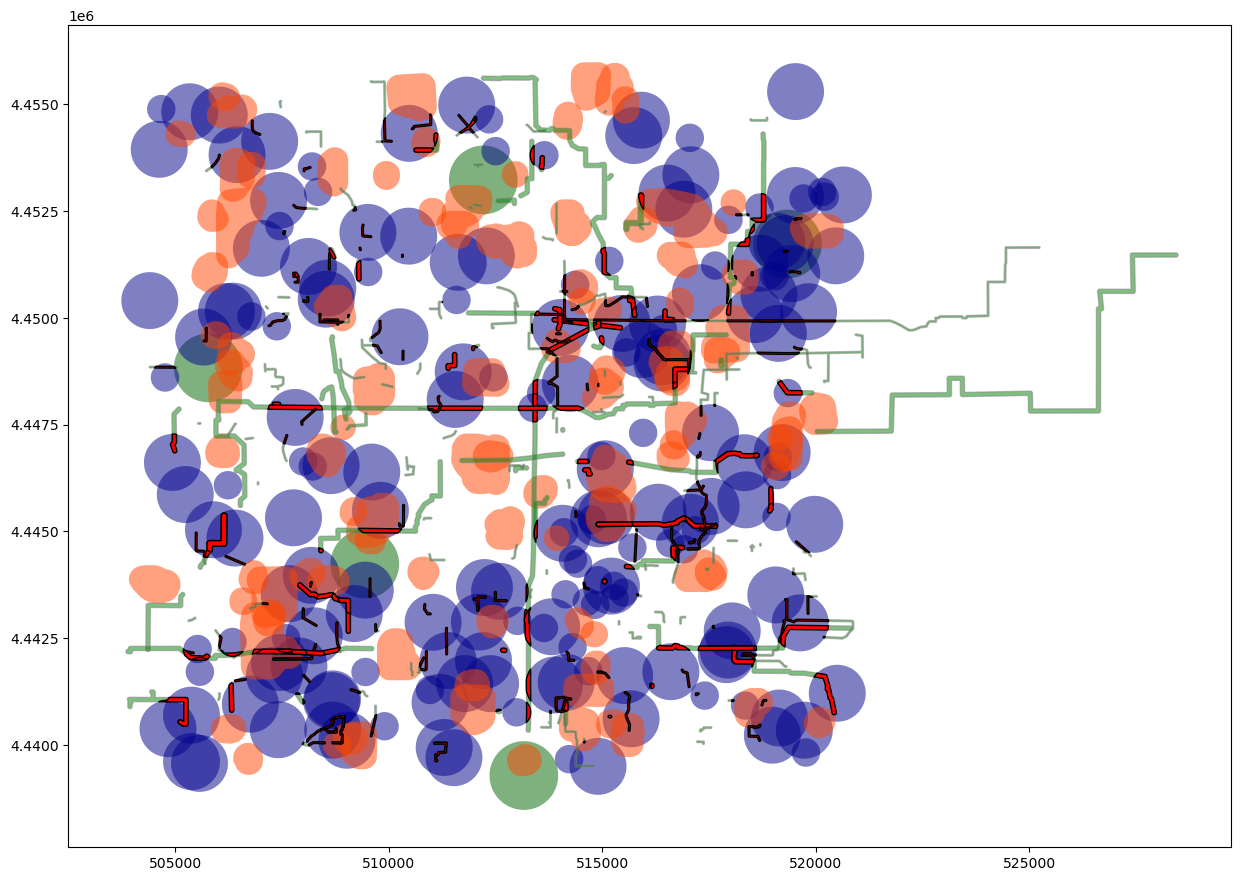

In [184]:
basemap = eagle.cx[505000:520000, 4440000:4455000].plot(color='darkgreen', alpha = 0.5, figsize=(15, 15))
basemap = raptor.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='darkblue', alpha = 0.5)
basemap = buowl.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='orangered', alpha = 0.5)
basemap = linear.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='green', alpha = 0.5, edgecolor='grey')
basemap = raptor_intersection_linear.cx[505000:520000, 4440000:4455000].plot(ax=basemap, color='red', edgecolor='k')

plt.show()

In [187]:
raptor_intersection = raptor_intersection[['Nest_ID', 'recentstat', 'recentspec', 'area_ha',
                                            'Project', 'type', 'length_m', 'geometry']]

raptor_intersection_linear = raptor_intersection_linear[['Nest_ID', 'recentstat', 'recentspec',
                                            'Project', 'type', 'length_m', 'length_intersection', 'geometry']]

raptor_intersection.to_file(f'{fpath}/intersections.gpkg', layer='raptor_buffer', driver='GPKG')
raptor_intersection_linear.to_file(f'{fpath}/intersections.gpkg', layer='raptor_linear', driver='GPKG')
fiona.listlayers(f'{fpath}/intersections.gpkg')

['buowl_buffer', 'raptor_buffer', 'raptor_linear']

# Groupby

In [188]:
# Reloading data
raptor_buffer = gpd.read_file(f'{fpath}/intersections.gpkg', layer = 'raptor_buffer')
raptor_linear = gpd.read_file(f'{fpath}/intersections.gpkg', layer = 'raptor_linear')

# What projects are impacted by Nest 68?
raptor_buffer[raptor_buffer['Nest_ID'] == 68]

,Nest_ID,recentstat,recentspec,area_ha,Project,type,length_m,geometry
103,68,ACTIVE NEST,Red-tail Hawk,54.581260,44,Pipeline,10375.850787,"POLYGON ((513323.870 4441035.415, 513290.219 4..."
128,68,ACTIVE NEST,Red-tail Hawk,0.542665,177,Flowline,321.835846,"POLYGON ((514246.883 4441961.855, 514221.852 4..."
131,68,ACTIVE NEST,Red-tail Hawk,24.825322,233,Pipeline,508.345449,"POLYGON ((514192.882 4440817.739, 514133.710 4..."
133,68,ACTIVE NEST,Red-tail Hawk,18.644832,371,Extraction,712.182301,"POLYGON ((514072.080 4440767.701, 514031.685 4..."
135,68,ACTIVE NEST,Red-tail Hawk,27.600509,381,Extraction,2624.223324,"POLYGON ((514133.710 4440789.753, 514086.834 4..."
151,68,ACTIVE NEST,Red-tail Hawk,2.350206,595,Access Road - Confirmed,620.002934,"POLYGON ((513769.928 4440748.594, 513770.116 4..."


In [189]:
# How many acres are impacated by Nest 68?
raptor_buffer[raptor_buffer['Nest_ID'] == 68].sum()['area_ha']

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\1789242530.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  raptor_buffer[raptor_buffer['Nest_ID'] == 68].sum()['area_ha']


128.54479423118713

In [190]:
# How many meters of the linear Project 1107 are impacted by Raptor nests?
raptor_linear[raptor_linear['Project'] == 1107]['length_intersection'].sum()

13644.2822204753

The groupby method allows to summarize a set of data aggregated over one or more groups.

In [191]:
raptor_buffer.groupby(['Project']).sum()

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\2041396436.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  raptor_buffer.groupby(['Project']).sum()


,Nest_ID,area_ha,length_m
Project,,,
2,601,0.048891,2060.846957
3,1457,53.618245,3680.722113
4,5054,691.005999,89067.423434
9,595,103.600378,5008.447943
11,291,53.001459,853.374520
...,...,...,...
1101,486,29.784765,903.963287
1102,980,19.330898,828.609473
1106,2963,551.640944,47842.142258


In [192]:
# Can look at specific columns
raptor_buffer.groupby(['Project']).sum()['area_ha'].sort_values()

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\898771254.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  raptor_buffer.groupby(['Project']).sum()['area_ha'].sort_values()


Project
912       0.000152
223       0.005037
495       0.017154
168       0.042619
452       0.044168
           ...    
82      585.936257
1107    604.534302
643     612.362032
4       691.005999
87      814.083742
Name: area_ha, Length: 493, dtype: float64

In [193]:
# Seeing number of nests impacted by each project
raptor_buffer.groupby(['Project']).count()['area_ha'].sort_values()

Project
2        1
647      1
646      1
633      1
632      1
        ..
119      8
1106     8
87      10
44      10
295     16
Name: area_ha, Length: 493, dtype: int64

In [194]:
# How many projects are impacted by each nest
raptor_buffer.groupby(['Nest_ID']).count()['area_ha'].sort_values()

Nest_ID
9991    1
696     1
693     1
334     1
336     1
       ..
747     5
206     6
4       6
68      6
32      9
Name: area_ha, Length: 453, dtype: int64

In [195]:
# Second level of grouping, i.e. how many acres of each project are impacted by each species of raptor
raptor_buffer.groupby(['Project', 'recentspec']).sum()['area_ha']

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\788503130.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  raptor_buffer.groupby(['Project', 'recentspec']).sum()['area_ha']


Project  recentspec    
2        Swainsons Hawk      0.048891
3        Red-tail Hawk      36.900163
         Swainsons Hawk     16.718082
4        Red-tail Hawk     405.637533
         Swainsons Hawk    285.368466
                              ...    
1106     Red-tail Hawk     427.874476
         Swainsons Hawk    123.766468
1107     Red-tail Hawk     579.124235
         Swainsons Hawk     25.410067
1108     Red-tail Hawk       3.824445
Name: area_ha, Length: 566, dtype: float64

In [196]:
# Aggregate functions that will be applied to each numeric column
raptor_buffer.groupby(['type', 'recentspec', 'recentstat']).agg(['count', 'sum'])['area_ha']

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\3997879942.py:2: FutureWarning: ['geometry'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  raptor_buffer.groupby(['type', 'recentspec', 'recentstat']).agg(['count', 'sum'])['area_ha']


count  \
type                    recentspec       recentstat                  
Access Road - Confirmed Northern Harrier INACTIVE NEST           1   
                        Red-tail Hawk    ACTIVE NEST            50   
                                         FLEDGED NEST           19   
                                         INACTIVE NEST          87   
                        Swainsons Hawk   ACTIVE NEST            15   
                                         FLEDGED NEST           14   
                                         INACTIVE NEST          20   
Access Road - Estimated Red-tail Hawk    ACTIVE NEST            12   
                                         FLEDGED NEST           12   
                                         INACTIVE NEST          22   
                        Swainsons Hawk   ACTIVE NEST             6   
                                         FLEDGED NEST            1   
                                         INACTIVE NEST           1   
Access Road - Old       Red-tail Hawk    ACTIVE NEST             1   
                                         INACTIVE NEST           1   
Electric Line           Red-tail Hawk    ACTIVE NEST            28   
                                         FLEDGED NEST            9   
                                         INACTIVE NEST          49   
                        Swainsons Hawk   ACTIVE NEST             4   
                                         FLEDGED NEST            7   
                                         INACTIVE NEST           8   
Extraction              Red-tail Hawk    ACTIVE NEST             8   
                                         COULD NOT SEE NEST      1   
                                         FLEDGED NEST            7   
                                         INACTIVE NEST          14   
                        Swainsons Hawk   ACTIVE NEST             1   
                                         INACTIVE NEST           4   
Flowline                Red-tail Hawk    ACTIVE NEST            23   
                                         FLEDGED NEST           13   
                                         INACTIVE NEST          47   
                        Swainsons Hawk   ACTIVE NEST             7   
                                         FLEDGED NEST            3   
                                         INACTIVE NEST          13   
Flowline, est.          Red-tail Hawk    ACTIVE NEST             7   
                                         COULD NOT SEE NEST      1   
                                         FLEDGED NEST            3   
                                         INACTIVE NEST          14   
                        Swainsons Hawk   ACTIVE NEST             3   
                                         FLEDGED NEST            1   
                                         INACTIVE NEST           3   
Flowline, est. - Old    Red-tail Hawk    INACTIVE NEST           1   
Flowline, old           Swainsons Hawk   ACTIVE NEST             2   
Other                   Red-tail Hawk    ACTIVE NEST             1   
                                         INACTIVE NEST           1   
Pipeline                Red-tail Hawk    ACTIVE NEST            66   
                                         COULD NOT SEE NEST      2   
                                         FLEDGED NEST           32   
                                         INACTIVE NEST         119   
                        Swainsons Hawk   ACTIVE NEST            34   
                                         FLEDGED NEST           14   
                                         INACTIVE NEST          35   

                                                                     sum  
type                    recentspec       recentstat                       
Access Road - Confirmed Northern Harrier INACTIVE NEST          4.578930  
                        Red-tail Hawk    ACTIVE NEST          906.041108  
                                         FLEDGED N

In [197]:
# Fine-tuned
raptor_buffer.groupby(['type', 'recentspec', 'recentstat']).agg({'Nest_ID': ['count'], 'area_ha': ['sum', 'mean', 'std']})

Nest_ID  \
                                                              count   
type                    recentspec       recentstat                   
Access Road - Confirmed Northern Harrier INACTIVE NEST            1   
                        Red-tail Hawk    ACTIVE NEST             50   
                                         FLEDGED NEST            19   
                                         INACTIVE NEST           87   
                        Swainsons Hawk   ACTIVE NEST             15   
                                         FLEDGED NEST            14   
                                         INACTIVE NEST           20   
Access Road - Estimated Red-tail Hawk    ACTIVE NEST             12   
                                         FLEDGED NEST            12   
                                         INACTIVE NEST           22   
                        Swainsons Hawk   ACTIVE NEST              6   
                                         FLEDGED NEST             1   
                                         INACTIVE NEST            1   
Access Road - Old       Red-tail Hawk    ACTIVE NEST              1   
                                         INACTIVE NEST            1   
Electric Line           Red-tail Hawk    ACTIVE NEST             28   
                                         FLEDGED NEST             9   
                                         INACTIVE NEST           49   
                        Swainsons Hawk   ACTIVE NEST              4   
                                         FLEDGED NEST             7   
                                         INACTIVE NEST            8   
Extraction              Red-tail Hawk    ACTIVE NEST              8   
                                         COULD NOT SEE NEST       1   
                                         FLEDGED NEST             7   
                                         INACTIVE NEST           14   
                        Swainsons Hawk   ACTIVE NEST              1   
                                         INACTIVE NEST            4   
Flowline                Red-tail Hawk    ACTIVE NEST             23   
                                         FLEDGED NEST            13   
                                         INACTIVE NEST           47   
                        Swainsons Hawk   ACTIVE NEST              7   
                                         FLEDGED NEST             3   
                                         INACTIVE NEST           13   
Flowline, est.          Red-tail Hawk    ACTIVE NEST              7   
                                         COULD NOT SEE NEST       1   
                                         FLEDGED NEST             3   
                                         INACTIVE NEST           14   
                        Swainsons Hawk   ACTIVE NEST              3   
                                         FLEDGED NEST             1   
                                         INACTIVE NEST            3   
Flowline, est. - Old    Red-tail Hawk    INACTIVE NEST            1   
Flowline, old           Swainsons Hawk   ACTIVE NEST              2   
Other                   Red-tail Hawk    ACTIVE NEST              1   
                                         INACTIVE NEST            1   
Pipeline                Red-tail Hawk    ACTIVE NEST             66   
                                         COULD NOT SEE NEST       2   
                                         FLEDGED NEST            32   
                                         INACTIVE NEST          119   
                        Swainsons Hawk   ACTIVE NEST             34   
                                         FLEDGED NEST            14   
                                         INACTIVE NEST           35   

                                                                 area_ha  \
                                                                     sum   
type                    recentspec       recentstat                      

In [198]:
# How many electric lines have Swainson Hawk nests within 333 meters?
# How many nests are affected by each electric line?
raptor_buffer[raptor_buffer['type'] == 'Electric Line'][raptor_buffer['recentspec'] == 'Swainsons Hawk'].groupby(['Project', 'recentspec']).agg({'Nest_ID': ['count']})

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,,Nest_ID
,,count
Project,recentspec,
3,Swainsons Hawk,1
97,Swainsons Hawk,1
140,Swainsons Hawk,1
202,Swainsons Hawk,1
280,Swainsons Hawk,1
285,Swainsons Hawk,1
323,Swainsons Hawk,1
330,Swainsons Hawk,2


# Pivot Tables

In [199]:
# We can sum all numeric fields by the Project column
raptor_buffer.groupby(['Project']).sum().head()

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\3102569940.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  raptor_buffer.groupby(['Project']).sum().head()


,Nest_ID,area_ha,length_m
Project,,,
2,601,0.048891,2060.846957
3,1457,53.618245,3680.722113
4,5054,691.005999,89067.423434
9,595,103.600378,5008.447943
11,291,53.001459,853.374520


In [200]:
# We can replicate this with the pivot_table method
pd.pivot_table(raptor_buffer, index = 'Project', aggfunc = 'sum').head()

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_32460\3152031437.py:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pd.pivot_table(raptor_buffer, index = 'Project', aggfunc = 'sum').head()


,Nest_ID,area_ha,length_m
Project,,,
2,601,0.048891,2060.846957
3,1457,53.618245,3680.722113
4,5054,691.005999,89067.423434
9,595,103.600378,5008.447943
11,291,53.001459,853.374520


In [201]:
# Can restrict columns to a single one or list of columns
pd.pivot_table(raptor_buffer, index = 'Project', values = 'area_ha', aggfunc = 'sum')

,area_ha
Project,
2,0.048891
3,53.618245
4,691.005999
9,103.600378
11,53.001459
...,...
1101,29.784765
1102,19.330898
1106,551.640944


In [202]:
pd.pivot_table(raptor_buffer, index = 'Project', values = ['area_ha', 'length_m'], aggfunc = 'sum')

,area_ha,length_m
Project,,
2,0.048891,2060.846957
3,53.618245,3680.722113
4,691.005999,89067.423434
9,103.600378,5008.447943
11,53.001459,853.374520
...,...,...
1101,29.784765,903.963287
1102,19.330898,828.609473
1106,551.640944,47842.142258


In [203]:
# We can add more levels of indexing
pd.pivot_table(raptor_buffer, index = ['Project', 'recentspec'], values = ['area_ha', 'length_m'], aggfunc = 'sum')

area_ha      length_m
Project recentspec                              
2       Swainsons Hawk    0.048891   2060.846957
3       Red-tail Hawk    36.900163   2453.814742
        Swainsons Hawk   16.718082   1226.907371
4       Red-tail Hawk   405.637533  33400.283788
        Swainsons Hawk  285.368466  55667.139646
...                            ...           ...
1106    Red-tail Hawk   427.874476  23921.071129
        Swainsons Hawk  123.766468  23921.071129
1107    Red-tail Hawk   579.124235  28264.217620
        Swainsons Hawk   25.410067   5652.843524
1108    Red-tail Hawk     3.824445     39.213896

[566 rows x 2 columns]

In [204]:
pd.pivot_table(raptor_buffer, index = ['Project', 'recentspec'], values = ['area_ha', 'length_m'], aggfunc = ['sum', 'count'])

sum                 count         
                           area_ha      length_m area_ha length_m
Project recentspec                                               
2       Swainsons Hawk    0.048891   2060.846957       1        1
3       Red-tail Hawk    36.900163   2453.814742       2        2
        Swainsons Hawk   16.718082   1226.907371       1        1
4       Red-tail Hawk   405.637533  33400.283788       3        3
        Swainsons Hawk  285.368466  55667.139646       5        5
...                            ...           ...     ...      ...
1106    Red-tail Hawk   427.874476  23921.071129       4        4
        Swainsons Hawk  123.766468  23921.071129       4        4
1107    Red-tail Hawk   579.124235  28264.217620       5        5
        Swainsons Hawk   25.410067   5652.843524       1        1
1108    Red-tail Hawk     3.824445     39.213896       1        1

[566 rows x 4 columns]

In [205]:
# columns parameters takes a categorical variable and produces same output for each variable
pd.pivot_table(raptor_buffer, index = ['Project', 'recentspec'], columns = 'recentstat',
                values = ['area_ha', 'length_m'], aggfunc = ['sum', 'count'])

sum                                  \
                           area_ha                                   
recentstat             ACTIVE NEST COULD NOT SEE NEST FLEDGED NEST   
Project recentspec                                                   
2       Swainsons Hawk    0.048891                NaN          NaN   
3       Red-tail Hawk    20.288833                NaN          NaN   
        Swainsons Hawk         NaN                NaN    16.718082   
4       Red-tail Hawk    31.949111                NaN   252.858321   
        Swainsons Hawk  216.569651                NaN          NaN   
...                            ...                ...          ...   
1106    Red-tail Hawk          NaN                NaN   116.529974   
        Swainsons Hawk   80.148257                NaN    43.618210   
1107    Red-tail Hawk   271.220008                NaN          NaN   
        Swainsons Hawk   25.410067                NaN          NaN   
1108    Red-tail Hawk          NaN                NaN     3.824445   

                                                                       \
                                          length_m                      
recentstat             INACTIVE NEST   ACTIVE NEST COULD NOT SEE NEST   
Project recentspec                                                      
2       Swainsons Hawk           NaN   2060.846957                NaN   
3       Red-tail Hawk      16.611330   1226.907371                NaN   
        Swainsons Hawk           NaN           NaN                NaN   
4       Red-tail Hawk     120.830101  11133.427929                NaN   
        Swainsons Hawk     68.798815  44533.711717                NaN   
...                              ...           ...                ...   
1106    Red-tail Hawk     311.344502           NaN                NaN   
        Swainsons Hawk           NaN  11960.535564                NaN   
1107    Red-tail Hawk     307.904226  11305.687048                NaN   
        Swainsons Hawk           NaN   5652.843524                NaN   
1108    Red-tail Hawk            NaN           NaN                NaN   

                                                         count  \
                                                       area_ha   
recentstat              FLEDGED NEST INACTIVE NEST ACTIVE NEST   
Project recentspec                                               
2       Swainsons Hawk           NaN           NaN         1.0   
3       Red-tail Hawk            NaN   1226.907371         1.0   
        Swainsons Hawk   1226.907371           NaN         NaN   
4       Red-tail Hawk   11133.427929  11133.427929         1.0   
        Swainsons Hawk           NaN  11133.427929         4.0   
...                              ...           ...         ...   
1106    Red-tail Hawk    5980.267782  17940.803347         NaN   
        Swainsons Hawk  11960.535564           NaN         2.0   
1107    Red-tail Hawk            NaN  16958.530572         2.0   
        Swainsons Hawk           NaN           NaN         1.0   
1108    Red-tail Hawk      39.213896           NaN         NaN   

                                                                      \
                                                                       
recentstat             COULD NOT SEE NEST FLEDGED NEST INACTIVE NEST   
Project recentspec                                                     
2       Swainsons Hawk                NaN          NaN           NaN   
3       Red-tail Hawk                 NaN          NaN           1.0   
        Swainsons Hawk                NaN          1.0           NaN   
4       Red-tail Hawk                 NaN          1.0           1.0   
        Swainsons Hawk                NaN          NaN           1.0   
...                                   ...          ...           ...   
1106    Red-tail Hawk                 NaN          1.0           3.0   
        Swainsons Hawk                NaN          2.0           NaN   
1107    Red-tail Hawk        

In [206]:
# Might be preferable to add another level of index
# Provides same results, formatted differently
pd.pivot_table(raptor_buffer, index = ['Project', 'recentspec', 'recentstat'],
                values = ['area_ha', 'length_m'], aggfunc = ['sum', 'count'])

sum                 count  \
                                         area_ha      length_m area_ha   
Project recentspec     recentstat                                        
2       Swainsons Hawk ACTIVE NEST      0.048891   2060.846957       1   
3       Red-tail Hawk  ACTIVE NEST     20.288833   1226.907371       1   
                       INACTIVE NEST   16.611330   1226.907371       1   
        Swainsons Hawk FLEDGED NEST    16.718082   1226.907371       1   
4       Red-tail Hawk  ACTIVE NEST     31.949111  11133.427929       1   
...                                          ...           ...     ...   
1106    Swainsons Hawk FLEDGED NEST    43.618210  11960.535564       2   
1107    Red-tail Hawk  ACTIVE NEST    271.220008  11305.687048       2   
                       INACTIVE NEST  307.904226  16958.530572       3   
        Swainsons Hawk ACTIVE NEST     25.410067   5652.843524       1   
1108    Red-tail Hawk  FLEDGED NEST     3.824445     39.213896       1   

                                               
                                     length_m  
Project recentspec     recentstat              
2       Swainsons Hawk ACTIVE NEST          1  
3       Red-tail Hawk  ACTIVE NEST          1  
                       INACTIVE NEST        1  
        Swainsons Hawk FLEDGED NEST         1  
4       Red-tail Hawk  ACTIVE NEST          1  
...                                       ...  
1106    Swainsons Hawk FLEDGED NEST         2  
1107    Red-tail Hawk  ACTIVE NEST          2  
                       INACTIVE NEST        3  
        Swainsons Hawk ACTIVE NEST          1  
1108    Red-tail Hawk  FLEDGED NEST         1  

[688 rows x 4 columns]

In [207]:
# Set margins parameter to True if you want to total each column
pd.pivot_table(raptor_buffer, index = ['Project', 'recentspec', 'recentstat'],
                values = ['area_ha', 'length_m'], aggfunc = ['sum', 'count'], margins = True)

sum                 count  \
                                           area_ha      length_m area_ha   
Project recentspec     recentstat                                          
2       Swainsons Hawk ACTIVE NEST        0.048891  2.060847e+03       1   
3       Red-tail Hawk  ACTIVE NEST       20.288833  1.226907e+03       1   
                       INACTIVE NEST     16.611330  1.226907e+03       1   
        Swainsons Hawk FLEDGED NEST      16.718082  1.226907e+03       1   
4       Red-tail Hawk  ACTIVE NEST       31.949111  1.113343e+04       1   
...                                            ...           ...     ...   
1107    Red-tail Hawk  ACTIVE NEST      271.220008  1.130569e+04       2   
                       INACTIVE NEST    307.904226  1.695853e+04       3   
        Swainsons Hawk ACTIVE NEST       25.410067  5.652844e+03       1   
1108    Red-tail Hawk  FLEDGED NEST       3.824445  3.921390e+01       1   
All                                   24173.027077  1.895566e+06     847   

                                               
                                     length_m  
Project recentspec     recentstat              
2       Swainsons Hawk ACTIVE NEST          1  
3       Red-tail Hawk  ACTIVE NEST          1  
                       INACTIVE NEST        1  
        Swainsons Hawk FLEDGED NEST         1  
4       Red-tail Hawk  ACTIVE NEST          1  
...                                       ...  
1107    Red-tail Hawk  ACTIVE NEST          2  
                       INACTIVE NEST        3  
        Swainsons Hawk ACTIVE NEST          1  
1108    Red-tail Hawk  FLEDGED NEST         1  
All                                       847  

[689 rows x 4 columns]

In [209]:
# transpose() can be applied to any dataframe to switch the index and columns
# Useful on smaller dataframes that result from summary methods
# Remove Project column from indexes
pd.pivot_table(raptor_buffer, index = ['recentspec', 'recentstat'], values = ['area_ha', 'length_m'],
                aggfunc = ['sum', 'count'])

sum                  count  \
                                          area_ha       length_m area_ha   
recentspec       recentstat                                                
Northern Harrier INACTIVE NEST           4.578930      83.107770       1   
Red-tail Hawk    ACTIVE NEST          5667.638739  485947.344882     196   
                 COULD NOT SEE NEST    170.874404   13169.607930       4   
                 FLEDGED NEST         3281.328757  180356.517356      95   
                 INACTIVE NEST       10993.171612  715421.516832     355   
Swainsons Hawk   ACTIVE NEST          1664.241910  274510.452439      72   
                 FLEDGED NEST          839.245278   89422.371409      40   
                 INACTIVE NEST        1551.947447  136655.197701      84   

                                              
                                    length_m  
recentspec       recentstat                   
Northern Harrier INACTIVE NEST             1  
Red-tail Hawk    ACTIVE NEST             196  
                 COULD NOT SEE NEST        4  
                 FLEDGED NEST             95  
                 INACTIVE NEST           355  
Swainsons Hawk   ACTIVE NEST              72  
                 FLEDGED NEST             40  
                 INACTIVE NEST            84

In [210]:
pd.pivot_table(raptor_buffer, index = ['recentspec', 'recentstat'], values = ['area_ha', 'length_m'],
                aggfunc = ['sum', 'count']).transpose()

recentspec     Northern Harrier  Red-tail Hawk                     \
recentstat        INACTIVE NEST    ACTIVE NEST COULD NOT SEE NEST   
sum   area_ha           4.57893    5667.638739         170.874404   
      length_m         83.10777  485947.344882       13169.607930   
count area_ha           1.00000     196.000000           4.000000   
      length_m          1.00000     196.000000           4.000000   

recentspec                                   Swainsons Hawk                \
recentstat       FLEDGED NEST  INACTIVE NEST    ACTIVE NEST  FLEDGED NEST   
sum   area_ha     3281.328757   10993.171612    1664.241910    839.245278   
      length_m  180356.517356  715421.516832  274510.452439  89422.371409   
count area_ha       95.000000     355.000000      72.000000     40.000000   
      length_m      95.000000     355.000000      72.000000     40.000000   

recentspec                     
recentstat      INACTIVE NEST  
sum   area_ha     1551.947447  
      length_m  136655.197701  
count area_ha       84.000000  
      length_m      84.000000

# Concatenating DataFrames

In [211]:
# Reloading data
buowl = gpd.read_file(f'{fpath}/BUOWL_Habitat.shp')
buowl.head()

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((-104.61687 40.16775, -104.61676 40.1..."
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((-104.65030 40.14220, -104.65014 40.1..."
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((-104.59917 40.11202, -104.59902 40.1..."
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((-104.69383 40.17870, -104.69360 40.1..."
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((-104.68393 40.19921, -104.68402 40.1..."


In [212]:
buowl['hist_occup'].value_counts()

Undetermined    359
Yes             110
Name: hist_occup, dtype: int64

In [213]:
# Separate into historical occupied habitats and undetermined
buowl_ho = buowl[buowl['hist_occup'] == 'Yes']
buowl_und = buowl[buowl['hist_occup'] == 'Undetermined']

# Concatenate
buowl_all = pd.concat([buowl_ho, buowl_und])

In [214]:
# Other dataframes
raptor_buffer = gpd.read_file(f"{fpath}/intersections.gpkg", layer = 'raptor_buffer')
buowl_buffer = gpd.read_file(f"{fpath}/intersections.gpkg", layer = 'buowl_buffer')

ec = pd.concat([raptor_buffer, buowl_buffer])
ec

,Nest_ID,recentstat,recentspec,area_ha,Project,type,length_m,geometry,habitat_id,hist_occup
0,361.0,INACTIVE NEST,Swainsons Hawk,52.653777,1003,Pipeline,1359.174276,"POLYGON ((517244.858 4460635.058, 517214.089 4...",NaN,NaN
1,219.0,INACTIVE NEST,Red-tail Hawk,80.678188,1003,Pipeline,1359.174276,"POLYGON ((517128.168 4460862.553, 517066.538 4...",NaN,NaN
2,362.0,INACTIVE NEST,Swainsons Hawk,5.553403,977,Flowline,272.268063,"POLYGON ((518262.976 4452422.693, 518273.548 4...",NaN,NaN
3,511.0,ACTIVE NEST,Swainsons Hawk,1.437528,977,Flowline,272.268063,"POLYGON ((518404.358 4452397.271, 518387.558 4...",NaN,NaN
4,3.0,ACTIVE NEST,Swainsons Hawk,32.055124,87,Pipeline,14108.343669,"POLYGON ((522030.303 4448243.418, 522013.503 4...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
408,NaN,NaN,NaN,1.690594,599,Access Road - Confirmed,391.400697,"POLYGON ((493333.526 4434586.059, 493331.487 4...",393.0,Undetermined
409,NaN,NaN,NaN,3.934133,277,Flowline,1126.003756,"POLYGON ((494034.646 4442424.241, 494053.959 4...",396.0,Undetermined
410,NaN,NaN,NaN,0.520475,981,Access Road - Confirmed,98.753176,"POLYGON ((501663.476 4448031.217, 501665.436 4...",400.0,Undetermined
411,NaN,NaN,NaN,1.958287,464,Access Road - Confirmed,1398.298546,"POLYGON ((521956.288 4434698.030, 521962.939 4...",404.0,Undetermined


Identical column names are combined automatically in the same column, but now there are two new columns *habitat_id* and *hist_occup* that reflect the columns in buowl_buffer that are not found in raptor_buffer.

In [215]:
buowl_buffer['recentspec'] = 'BUOWL'

# Pick columns
buowl_buffer.columns = ['Nest_ID', 'recentstat', 'Project', 'type', 'length_m', 'area_ha', 'geometry', 'recentspec']

ec = pd.concat([raptor_buffer, buowl_buffer])
ec

,Nest_ID,recentstat,recentspec,area_ha,Project,type,length_m,geometry
0,361,INACTIVE NEST,Swainsons Hawk,52.653777,1003,Pipeline,1359.174276,"POLYGON ((517244.858 4460635.058, 517214.089 4..."
1,219,INACTIVE NEST,Red-tail Hawk,80.678188,1003,Pipeline,1359.174276,"POLYGON ((517128.168 4460862.553, 517066.538 4..."
2,362,INACTIVE NEST,Swainsons Hawk,5.553403,977,Flowline,272.268063,"POLYGON ((518262.976 4452422.693, 518273.548 4..."
3,511,ACTIVE NEST,Swainsons Hawk,1.437528,977,Flowline,272.268063,"POLYGON ((518404.358 4452397.271, 518387.558 4..."
4,3,ACTIVE NEST,Swainsons Hawk,32.055124,87,Pipeline,14108.343669,"POLYGON ((522030.303 4448243.418, 522013.503 4..."
...,...,...,...,...,...,...,...,...
408,393,Undetermined,BUOWL,1.690594,599,Access Road - Confirmed,391.400697,"POLYGON ((493333.526 4434586.059, 493331.487 4..."
409,396,Undetermined,BUOWL,3.934133,277,Flowline,1126.003756,"POLYGON ((494034.646 4442424.241, 494053.959 4..."
410,400,Undetermined,BUOWL,0.520475,981,Access Road - Confirmed,98.753176,"POLYGON ((501663.476 4448031.217, 501665.436 4..."
411,404,Undetermined,BUOWL,1.958287,464,Access Road - Confirmed,1398.298546,"POLYGON ((521956.288 4434698.030, 521962.939 4..."


In [216]:
# Easier to create data summaries
pd.pivot_table(ec, index = ['Project', 'recentspec', 'recentstat'], values = 'area_ha',
                aggfunc = ['sum', 'count'])

sum   count
                                         area_ha area_ha
Project recentspec     recentstat                       
2       Swainsons Hawk ACTIVE NEST      0.048891       1
3       BUOWL          Undetermined     1.103370       1
        Red-tail Hawk  ACTIVE NEST     20.288833       1
                       INACTIVE NEST   16.611330       1
        Swainsons Hawk FLEDGED NEST    16.718082       1
...                                          ...     ...
1106    Swainsons Hawk FLEDGED NEST    43.618210       2
1107    Red-tail Hawk  ACTIVE NEST    271.220008       2
                       INACTIVE NEST  307.904226       3
        Swainsons Hawk ACTIVE NEST     25.410067       1
1108    Red-tail Hawk  FLEDGED NEST     3.824445       1

[1005 rows x 2 columns]

# Merging dataframes

Combine the attributes of several dataframes based on a common value.

In [217]:
eagle = gpd.read_file(f'{fpath}/BAEA_Nests.shp')
eagle_sources = pd.read_csv(f'{fpath}/BAEA_sources.csv')
eagle_surveys = pd.read_csv(f'{fpath}/BAEA_surveys.csv')
eagle.head()

,postgis_fi,lat_y_dd,long_x_dd,status,nest_id,geometry
0,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607)
1,35,40.158003,-104.551141,INACTIVE LOCATION,35,POINT (-104.55114 40.15800)
2,36,39.929381,-104.970620,ACTIVE NEST,36,POINT (-104.97062 39.92938)
3,37,40.556888,-104.974663,ACTIVE NEST,37,POINT (-104.97466 40.55689)
4,46,40.055709,-105.014636,ACTIVE NEST,46,POINT (-105.01464 40.05571)


In [218]:
eagle_sources

,code,source
0,1,Colorado Fish Wildlife and Parks
1,2,US Fish and Wildlife Service
2,3,ABC Environmental
3,4,123 Environmental


In [219]:
eagle_surveys

,id,nest,surveyor,date,result
0,6.0,52,Dan Smith,2015-07-11,ACTIVE NEST
1,8.0,54,Mike Miller,2015-05-08,ACTIVE NEST
2,9.0,25,Mike Miller,2015-05-13,INACTIVE NEST
3,10.0,65,Mike Miller,2015-08-21,INACTIVE NEST
4,11.0,33,Mike Miller,2015-06-26,ACTIVE NEST
...,...,...,...,...,...
1992,1997.0,64,Mike Miller,2015-06-26,FLEDGED NEST
1993,1998.0,56,George Baker,2015-08-17,ACTIVE NEST
1994,1999.0,16,Dan Smith,2015-08-30,INACTIVE NEST
1995,2000.0,60,Mike Miller,2015-07-22,INACTIVE NEST


In [222]:
# Let's add a code field to the eagles data and populate it with a random number from 1 to 4
eagle['code'] = np.random.randint(1, 5, size = eagle.shape[0])
eagle.sort_values('nest_id')

,postgis_fi,lat_y_dd,long_x_dd,status,nest_id,geometry,code
0,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607),4
9,2,40.235243,-104.973296,ACTIVE NEST,2,POINT (-104.97330 40.23524),1
10,3,40.385732,-104.828742,ACTIVE NEST,3,POINT (-104.82874 40.38573),3
11,4,40.450020,-104.623042,ACTIVE NEST,4,POINT (-104.62304 40.45002),3
12,5,39.983218,-104.895140,ACTIVE NEST,5,POINT (-104.89514 39.98322),2
...,...,...,...,...,...,...,...
62,68,39.838158,-104.292067,ACTIVE NEST,68,POINT (-104.29207 39.83816),2
63,69,40.385771,-104.601066,ACTIVE NEST,69,POINT (-104.60107 40.38577),3
64,73,39.885310,-104.850000,ACTIVE NEST,73,POINT (-104.85000 39.88531),1
65,75,40.005430,-104.726140,INACTIVE LOCATION,75,POINT (-104.72614 40.00543),3


In [223]:
# Merge eagle with eagle_source
eagle_merge = pd.merge(eagle, eagle_sources, how = 'inner', on = 'code').sort_values('nest_id')
eagle_merge

,postgis_fi,lat_y_dd,long_x_dd,status,nest_id,geometry,code,source
0,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607),4,123 Environmental
22,2,40.235243,-104.973296,ACTIVE NEST,2,POINT (-104.97330 40.23524),1,Colorado Fish Wildlife and Parks
34,3,40.385732,-104.828742,ACTIVE NEST,3,POINT (-104.82874 40.38573),3,ABC Environmental
35,4,40.450020,-104.623042,ACTIVE NEST,4,POINT (-104.62304 40.45002),3,ABC Environmental
55,5,39.983218,-104.895140,ACTIVE NEST,5,POINT (-104.89514 39.98322),2,US Fish and Wildlife Service
...,...,...,...,...,...,...,...,...
65,68,39.838158,-104.292067,ACTIVE NEST,68,POINT (-104.29207 39.83816),2,US Fish and Wildlife Service
51,69,40.385771,-104.601066,ACTIVE NEST,69,POINT (-104.60107 40.38577),3,ABC Environmental
32,73,39.885310,-104.850000,ACTIVE NEST,73,POINT (-104.85000 39.88531),1,Colorado Fish Wildlife and Parks
52,75,40.005430,-104.726140,INACTIVE LOCATION,75,POINT (-104.72614 40.00543),3,ABC Environmental


In [224]:
# Source field can now be used normally ex. index for a pivot table
pd.pivot_table(eagle_merge, index = ['source', 'status'], values = 'nest_id', aggfunc = 'count')

nest_id
source                           status                    
123 Environmental                ACTIVE NEST             12
                                 INACTIVE LOCATION        7
ABC Environmental                ACTIVE NEST             12
                                 INACTIVE LOCATION        8
Colorado Fish Wildlife and Parks ACTIVE NEST              9
                                 INACTIVE LOCATION        5
US Fish and Wildlife Service     ACTIVE NEST             11
                                 INACTIVE LOCATION        3

In [226]:
# Can be merged again with eagle_survey
eagle_merge2 = pd.merge(eagle_merge, eagle_surveys, how = 'inner', left_on = 'nest_id', right_on = 'nest').sort_values('nest_id')
eagle_merge2

,postgis_fi,lat_y_dd,long_x_dd,status,nest_id,geometry,code,source,id,nest,surveyor,date,result
0,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607),4,123 Environmental,518.0,1,Dan Smith,2015-07-16,ACTIVE NEST
18,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607),4,123 Environmental,1865.0,1,Mike Miller,2015-04-02,INACTIVE NEST
17,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607),4,123 Environmental,1856.0,1,Dan Smith,2015-08-07,INACTIVE NEST
16,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607),4,123 Environmental,1815.0,1,Dan Smith,2015-05-05,INACTIVE NEST
14,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (-104.80355 40.26607),4,123 Environmental,1673.0,1,Dan Smith,2015-07-19,INACTIVE NEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,76,40.090090,-104.878150,INACTIVE LOCATION,76,POINT (-104.87815 40.09009),2,US Fish and Wildlife Service,184.0,76,George Baker,2015-08-20,FLEDGED NEST
1748,76,40.090090,-104.878150,INACTIVE LOCATION,76,POINT (-104.87815 40.09009),2,US Fish and Wildlife Service,124.0,76,Dan Smith,2015-05-26,INACTIVE NEST
1764,76,40.090090,-104.878150,INACTIVE LOCATION,76,POINT (-104.87815 40.09009),2,US Fish and Wildlife Service,1834.0,76,Mike Miller,2015-08-06,INACTIVE NEST
1755,76,40.090090,-104.878150,INACTIVE LOCATION,76,POINT (-104.87815 40.09009),2,US Fish and Wildlife Service,903.0,76,Mike Miller,2015-07-04,INACTIVE NEST


# Spatial Joins|

In [227]:
# Reloading data
raptor = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
county = gpd.read_file(f"{fpath}/colorado_counties.shp")

# Spatial join
raptor_cnty = gpd.sjoin(raptor, county, how = 'left', op = 'within')
raptor_cnty

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,index_right,OBJECTID,COUNTYFP,Shape_Leng,Shape_Area,low,lowmod,LMMI,lowmoduniv,lowmod_pct,NAMELSAD10
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891),62.0,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,Weld County
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089),62.0,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,Weld County
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694),22.0,23.0,043,3.087440,0.410131,10815.0,18520.0,26160.0,36180.0,0.511885,Fremont County
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215),62.0,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,Weld County
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571),62.0,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,Weld County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297),7.0,8.0,014,1.174635,0.009158,9045.0,17315.0,29050.0,60355.0,0.286886,Broomfield County
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975),0.0,1.0,001,4.321021,0.322758,132545.0,231255.0,334950.0,467200.0,0.494981,Adams County
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432),62.0,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,Weld County
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443),62.0,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,Weld County


In [228]:
# If we want a few columns from the county GDF, subset that by column
raptor_cnty = gpd.sjoin(raptor, county[['NAMELSAD10', 'geometry']], how = 'left', op = 'within')
raptor_cnty

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry,index_right,NAMELSAD10
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891),62.0,Weld County
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089),62.0,Weld County
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694),22.0,Fremont County
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215),62.0,Weld County
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571),62.0,Weld County
...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297),7.0,Broomfield County
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975),0.0,Adams County
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432),62.0,Weld County
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443),62.0,Weld County


In [229]:
# We can see how many nests are in each county
pd.pivot_table(raptor_cnty, index = ['NAMELSAD10', 'recentspec'], values = 'Nest_ID', aggfunc = 'count')

Nest_ID
NAMELSAD10        recentspec               
Adams County      Red-tail Hawk          22
                  Swainsons Hawk         15
Arapahoe County   Red-tail Hawk           3
                  Swainsons Hawk          5
Boulder County    Red-tail Hawk          21
                  Swainsons Hawk         19
Broomfield County Red-tail Hawk           4
                  Swainsons Hawk          2
Cheyenne County   Swainsons Hawk          1
Denver County     Swainsons Hawk          2
Fremont County    Swainsons Hawk          1
Larimer County    Red-tail Hawk          12
                  Swainsons Hawk          6
Morgan County     Red-tail Hawk           1
Weld County       Northern Harrier        1
                  RTHA                    1
                  Red-tail Hawk         435
                  SWHA                    1
                  Swainsons Hawk        326

In [230]:
# We COULD join on the basis of an attribute relationship rather than spatial
pd.merge(raptor_cnty, county, how = 'left', on = 'NAMELSAD10')

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry_x,index_right,NAMELSAD10,OBJECTID,COUNTYFP,Shape_Leng,Shape_Area,low,lowmod,LMMI,lowmoduniv,lowmod_pct,geometry_y
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891),62.0,Weld County,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,"MULTIPOLYGON (((-104.97628 40.03305, -104.9752..."
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089),62.0,Weld County,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,"MULTIPOLYGON (((-104.97628 40.03305, -104.9752..."
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694),22.0,Fremont County,23.0,043,3.087440,0.410131,10815.0,18520.0,26160.0,36180.0,0.511885,"POLYGON ((-105.39542 38.69753, -105.39281 38.6..."
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215),62.0,Weld County,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,"MULTIPOLYGON (((-104.97628 40.03305, -104.9752..."
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571),62.0,Weld County,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,"MULTIPOLYGON (((-104.97628 40.03305, -104.9752..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,911.0,40.006950,-104.894370,2015-08-18,Red-tail Hawk,INACTIVE NEST,911,POINT (-104.98394 40.00297),7.0,Broomfield County,8.0,014,1.174635,0.009158,9045.0,17315.0,29050.0,60355.0,0.286886,"MULTIPOLYGON (((-105.09996 39.95799, -105.0999..."
875,912.0,39.998876,-104.900128,2015-09-01,Red-tail Hawk,INACTIVE NEST,912,POINT (-104.84766 39.96975),0.0,Adams County,1.0,001,4.321021,0.322758,132545.0,231255.0,334950.0,467200.0,0.494981,"POLYGON ((-103.86177 40.00123, -103.86147 40.0..."
876,NaN,NaN,NaN,2020-05-08,Northern Harrier,INACTIVE NEST,9991,POINT (-104.95039 40.24432),62.0,Weld County,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,"MULTIPOLYGON (((-104.97628 40.03305, -104.9752..."
877,NaN,NaN,NaN,2020-05-05,SWHA,INACTIVE NEST,1001,POINT (-104.94502 40.24443),62.0,Weld County,63.0,123,5.099761,1.106108,56122.0,100164.0,150579.0,264445.0,0.378771,"MULTIPOLYGON (((-104.97628 40.03305, -104.9752..."
